  # Train simple Fully Connected NN on (1472) profiles to classify TPSA  :

# Setup

In [1]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import os
import sys
import random
from functools import partial
from typing import List, Tuple
from types import SimpleNamespace
import yaml
import pprint
import logging
from datetime import datetime
for p in ['../','../../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=180, profile=None, sci_mode=None)
torch.manual_seed(42);  # seed rng for reproducibility
pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

# os.environ["WANDB_NOTEBOOK_NAME"] = "6.3_Profiles_NN.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

torch.set_num_threads(4)  # <--- limit to ~ 2 CPUs
torch.get_num_threads()

insert ../
['../', '../../..', '../src', '/home/kevin/WSL-shared/cellpainting/cj-datasets/Notebooks-TPSA_Classification', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


4

In [6]:
# from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle, get_device
import KevinsRoutines.utils as myutils
# import snnl.utils as utils
# from utils.utils_ptsnnl import display_cellpainting_batch, get_device
from src.utils.utils_cellpainting import label_counts, balance_datasets,save_checkpoint, load_checkpoint 
from src.utils.dataloader import  InfiniteDataLoader, CellpaintingDataset, custom_collate_fn, dynamic_collate_fn 
from src.utils.utils_notebooks import plot_cls_metrics, compute_classification_metrics, run_model_on_test_data,\
                                train, validation, accuracy_fn, fit, build_model, define_profile_datasets, run_classification_inference

In [7]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version   : {pd.__version__}  ")

2024-12-20 13:04:02,458 - __main__ - INFO: -  Pytorch version  : 2.2.0
2024-12-20 13:04:02,459 - __main__ - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2024-12-20 13:04:02,461 - __main__ - INFO: -  Pandas version   : 2.2.2  


In [8]:
# Set visible GPU device 
# ----------------------------------------------
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
myutils.set_device(2);
DEVICE = myutils.get_device(verbose = True);
myutils.set_global_seed(9999)
print(DEVICE)

 Switched to: "cuda:2"   Device Name: NVIDIA TITAN Xp               


'cuda:2'

Dev Id   Device Name                    Total Memory                     InUse                            Free Memory 
   0     Quadro GV100                   34,069,872,640 B/ (31.73 GB)  	 5,733,613,568 B / (5.34 GB)  	 28,336,259,072 B / (26.39 GB)  
   1     Quadro GV100                   34,069,872,640 B/ (31.73 GB)  	 645,922,816 B / (0.60 GB)  	 33,423,949,824 B / (31.13 GB)  
   2     NVIDIA TITAN Xp                12,774,539,264 B/ (11.90 GB)  	 388,104,192 B / (0.36 GB)  	 12,386,435,072 B / (11.54 GB)   *** CURRENT DEVICE *** 

 Current CUDA Device is:  "cuda:2"  Device Name: NVIDIA TITAN Xp
 Seed value set to 9999 in random, np.random, and torch
cuda:2


In [9]:
try:
    del model
except Exception as e:
    pass

# main(args)

In [10]:
LATENT_DIM    = 1471
# HIDDEN_1      = 512
COMPOUNDS_PER_BATCH = 600
TPSA_THRESHOLD = 100

METADATA_COLS = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA', 'Metadata_Permiation']
input_cols = LATENT_DIM + len(METADATA_COLS)
print(len(METADATA_COLS))
print(input_cols)

INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/"
CKPT_PATH = "../saved_tpsa_models/profile_models"

11
1482


## Input Dataloader

In [11]:
# TRAIN_INPUT_FILE = f"3sample_profiles_1482_HashOrder_training.csv"
# VAL_INPUT_FILE   = f"3sample_profiles_1482_HashOrder_training_sub_val.csv"
# TEST_INPUT_FILE  = f"3sample_profiles_1482_HashOrder_training_sub_test.csv"

TRAIN_INPUT_FILE = f"3sample_profiles_1482_HashOrder_training_277200.csv"
VAL_INPUT_FILE   = f"3sample_profiles_1482_HashOrder_test_12600.csv"
TEST_INPUT_FILE  = f"3sample_profiles_1482_HashOrder_validation_21600.csv"

TRAIN_INPUT = os.path.join(INPUT_PATH, TRAIN_INPUT_FILE)
VAL_INPUT   = os.path.join(INPUT_PATH, VAL_INPUT_FILE)
TEST_INPUT  = os.path.join(INPUT_PATH, TEST_INPUT_FILE)

print(f" TRAIN_INPUT:  {TRAIN_INPUT}")
print(f" VAL_INPUT  :  {VAL_INPUT }")
print(f" TEST_INPUT :  {TEST_INPUT }")

 TRAIN_INPUT:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_training_277200.csv
 VAL_INPUT  :  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test_12600.csv
 TEST_INPUT :  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_validation_21600.csv


In [12]:
## total rows = 346,542
## Rows on 3sample_profiles_1482_HashOrder_training.csv: 312,000
## Split to:
##     Train      : 277,200     (312,000 - (21,600+12,600+600))
##     Validation :  21,600
##     Test       :  12,600
##     left over  :     600
# cellpainting_args = {'compounds_per_batch': COMPOUNDS_PER_BATCH,
#                      'training_path'  : TRAIN_INPUT,
#                      'validation_path': VAL_INPUT,
#                      'test_path'      : TEST_INPUT,
#                      'train_start'    : 0,
#                      'train_end'      : 277_200,  # was 276,000
#                      'val_start'      : 0,
#                      'val_end'        : 21_600,  # was 300,000 
#                      'test_start'     : 0,
#                      'test_end'       : 12_600,  # 34_542
#                      'tpsa_threshold' : 100
#                     }
cellpainting_args = {'compounds_per_batch': COMPOUNDS_PER_BATCH,
                     'training_path'      : TRAIN_INPUT,
                     'validation_path'    : VAL_INPUT,
                     'test_path'          : TEST_INPUT,
                     'train_start'        : 21_600, ## arbritary jump
                     'train_end'          : 34_200,
                     'val_start'          : 9_000,
                     'val_end'            : 21_600,
                     'test_start'         : 0,
                     'test_end'           : 12_600,
                     'tpsa_threshold'     : 100
                    }

cellpainting_args

{'compounds_per_batch': 600,
 'training_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_training_277200.csv',
 'validation_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test_12600.csv',
 'test_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_validation_21600.csv',
 'train_start': 21600,
 'train_end': 34200,
 'val_start': 9000,
 'val_end': 21600,
 'test_start': 0,
 'test_end': 12600,
 'tpsa_threshold': 100}

In [13]:
#### Load CellPainting Dataset
# data : keys to the dataset settings (and resulting keys in output dictionary)
dataset = dict()
data_loader = dict()

print(f" load {dataset}")
for datatype in ['train', 'val', 'test']:
    dataset[datatype] = CellpaintingDataset(type = datatype, **cellpainting_args)
    data_loader[datatype] = InfiniteDataLoader(dataset = dataset[datatype], batch_size=1, shuffle = False, num_workers = 0,
                                               collate_fn = partial(dynamic_collate_fn, tpsa_threshold = dataset[datatype].tpsa_threshold) )

2024-12-20 13:04:19,610 - src.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-12-20 13:04:19,611 - src.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_training_277200.csv
2024-12-20 13:04:19,612 - src.utils.dataloader - INFO: -  type    :  train
2024-12-20 13:04:19,613 - src.utils.dataloader - INFO: -  start   :  21600
2024-12-20 13:04:19,614 - src.utils.dataloader - INFO: -  end     :  34200
2024-12-20 13:04:19,614 - src.utils.dataloader - INFO: -  numrows :  12600
2024-12-20 13:04:19,615 - src.utils.dataloader - INFO: -  names   :  None     usecols :  None
2024-12-20 13:04:19,616 - src.utils.dataloader - INFO: -  batch_size  :  1
2024-12-20 13:04:19,617 - src.utils.dataloader - INFO: -  sample_size :  3
2024-12-20 13:04:19,617 - src.utils.dataloader - INFO: -  compounds_per_batch :  600
2024-12-20 13:04:19,618 - src.utils.dataloader - INFO: -  rows per batch

 load {}
 Dataset size: 12600   rows per batch: 1800 
 Dataset size: 12600   rows per batch: 1800 
 Dataset size: 12600   rows per batch: 1800 


### misc stuff

In [13]:
# %%timeit
# for dataset in ['train', 'val', 'test']:
#     for idx, batch in enumerate(data_loader[dataset]):
#         print(batch[0].shape[0], batch[1].sum())
#         # display_cellpainting_batch(idx, batch)
#         if idx == 1:
#             break

In [15]:
# # -----------------------------------------
# #  Count pos/neg labels in each dataset
# # -----------------------------------------
for datatype in ['train', 'val', 'test']:
    MINIBATCH_SIZE = data_loader[datatype].dataset.sample_size * data_loader[datatype].dataset.compounds_per_batch
    print(f" {datatype.capitalize()} Minibatch size : {MINIBATCH_SIZE}") 
print()

for datatype in ['train', 'val', 'test']:
    # for datatype in ['val', 'test']:
    minibatches = len(data_loader[datatype]) // MINIBATCH_SIZE
    ttl_rows = 0
    ttl_pos_labels = 0 
    with tqdm.tqdm(enumerate(data_loader[datatype]), initial=0, total = minibatches, position=0, file=sys.stdout,
                   leave= False, desc=f" Count labels ") as t_warmup:
        for batch_count, (batch_features, batch_labels, _, _, _, _, _) in t_warmup:
            ttl_rows += batch_labels.shape[0]
            ttl_pos_labels += batch_labels.sum()
    ttl_neg_labels = ttl_rows - ttl_pos_labels
    ttl = f"\n Dataset: {datatype} -  len of {datatype} data loader: {len(data_loader[datatype])}   number of batches: {minibatches}"
    print(ttl)
    print('-'*len(ttl))
    print(f" total rows     : {ttl_rows:7d}")
    print(f" total pos rows : {ttl_pos_labels:7.0f} - {ttl_pos_labels*100.0/ttl_rows:5.2f}%")
    print(f" total neg rows : {ttl_neg_labels:7.0f} - {ttl_neg_labels*100.0/ttl_rows:5.2f}%")
    print()

 Train Minibatch size : 1800
 Val Minibatch size : 1800
 Test Minibatch size : 1800

                                                                                                                                                                                                 
 Dataset: train -  len of train data loader: 12600   number of batches: 7
--------------------------------------------------------------------------
 total rows     :   12600
 total pos rows :    1479 - 11.74%
 total neg rows :   11121 - 88.26%

                                                                                                                                                                                                 
 Dataset: val -  len of val data loader: 12600   number of batches: 7
----------------------------------------------------------------------
 total rows     :    3600
 total pos rows :     417 - 11.58%
 total neg rows :    3183 - 88.42%

                                           

     Train Minibatch size : 1800

     Dataset: train -  len of train data loader: 12600   number of batches: 7
    --------------------------------------------------------------------------
     total rows     :   12600
     total pos rows :    1479 - 11.74%
     total neg rows :   11121 - 88.26%

     Dataset: val -  len of val data loader: 12600   number of batches: 7
    ----------------------------------------------------------------------
     total rows     :    3600
     total pos rows :     417 - 11.58%
     total neg rows :    3183 - 88.42%

     Dataset: test -  len of test data loader: 12600   number of batches: 7
    ------------------------------------------------------------------------
     total rows     :   12600
     total pos rows :    1536 - 12.19%
     total neg rows :   11064 - 87.81%

     Minibatch size : 1800 

     Dataset: train -  len of train data loader: 277200   number of batches: 154
    ------------------------------
     total rows     :  277200
     total pos rows :   33129 - 11.95%
     total neg rows :  244071 - 88.05%
      
     Dataset: val - len of val data loader: 21600   number of batches: 12
    ------------------------------
     total rows     :   21600
     total pos rows :    2532 - 11.72%
     total neg rows :   19068 - 88.28%

     Dataset: test - len of test data loader: 12600   number of batches: 7
    ------------------------------
     total rows     :   12600
     total pos rows :    1431 - 11.36%
     total neg rows :   11169 - 88.64%


     Minibatch size : 1800 
    
     Dataset: train -  len of train data loader: 277200   number of batches: 154
    ------------------------------
     total rows     :  277200
     total pos rows :   33129 - 11.95%
     total neg rows :  244071 - 88.05%
      
     Dataset: val - len of val data loader: 21600   number of batches: 12
    ------------------------------
     total rows     :   21600
     total pos rows :    2532 - 11.72%
     total neg rows :   19068 - 88.28%
    
     Dataset: test - len of test data loader: 12600   number of batches: 7
    ------------------------------
     total rows     :   12600
     total pos rows :    1431 - 11.36%
     total neg rows :   11169 - 88.64%

  - 4 layer model :

    Input --> Hidden1 --> (BN/NL) ---> Hidden2 ---> (BN/NL) ---> Hidden3 --->  (BN/NL) ---> 1

     - **20240912_0400** : Run on 4 FC layer model - Relu non linearities (NO Batch Norm)
     
     - **20240913_0700** : Run on 4 FC layer model - with BATCH NORM and tanh non linearities

 - 1 layer model :
 
     - **20240916_1800** : Run on 1 FC layer model - Input --> 256 --> Tanh --> 1
     
     - **20240921_0600** : Run on 1 FC layer model - Input --> 512 --> Tanh --> 1     




# Inference evaluation - (Single 256 Layer, Tanh)

 -  Model: **20240916_1800** - Single layer 256

In [16]:
CKPT_PATH

'../saved_tpsa_models/profile_models'

In [17]:
# AE_RUNMODE = 'base'
# AE_DATETIME = "20240923_1943"     # Autoencoder training - Baseline, CPB = 600, Latent 250, WD = 0.001 (SNN Factor 0)
# AE_CKPTTYPE = "LAST"
AE_LATENT_DIM = 1471
# RUN_DATETIME = '20240916_1800'
# RUN_DATETIME = '20240916_1801'
# RUN_DATETIME = '20240916_1802'
RUN_DATETIME = '20240916_1803'

input_num_cols = AE_LATENT_DIM + len(METADATA_COLS)

MODEL_TYPE = 'single_layer'
n_input    = AE_LATENT_DIM  # the embedding dimensionality 
 
n_hidden_1 = 256  # the number of neurons in the hidden layer of the MLP
n_hidden_2 = 256  # the number of neurons in the hidden layer of the MLP
n_hidden_3 = 128

CKPT_FILE_BASE = f"NN_{input_num_cols}profiles_cpb{COMPOUNDS_PER_BATCH}_{RUN_DATETIME}_ep_{{ep}}"
CKPT_FILE = os.path.join(CKPT_PATH, CKPT_FILE_BASE )
print(CKPT_FILE)
print(CKPT_FILE.format(ep=999))
print()


# data_loader = define_inference_datasets(cellpainting_args, AE_RUNMODE, AE_DATETIME, input_num_cols, AE_CKPTTYPE, INPUT_PATH)
model = build_model(MODEL_TYPE, input = n_input, hidden_1 = n_hidden_1, hidden_2 = n_hidden_2, hidden_3=n_hidden_3, device =DEVICE)

../saved_tpsa_models/profile_models/NN_1482profiles_cpb600_20240916_1803_ep_{ep}
../saved_tpsa_models/profile_models/NN_1482profiles_cpb600_20240916_1803_ep_999

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Mult-Adds                 Trainable
Sequential                               [30, 1471]                [30, 1]                   --                             --                   --                        True
├─Linear: 1-1                            [30, 1471]                [30, 256]                 376,832                    99.93%                   11,304,960                True
│    └─weight                                                                                ├─376,576
│    └─bias                                                                                  └─256
├─Tanh: 1-2                              [30, 256]                 [30, 256]                 --        

### t0

100 Test  Acc : 81.57 %    ROC Auc: 0.5522    PR Auc:0.1267    F1: 0.1387    Prec: 0.1612  Recall: 0.1217    


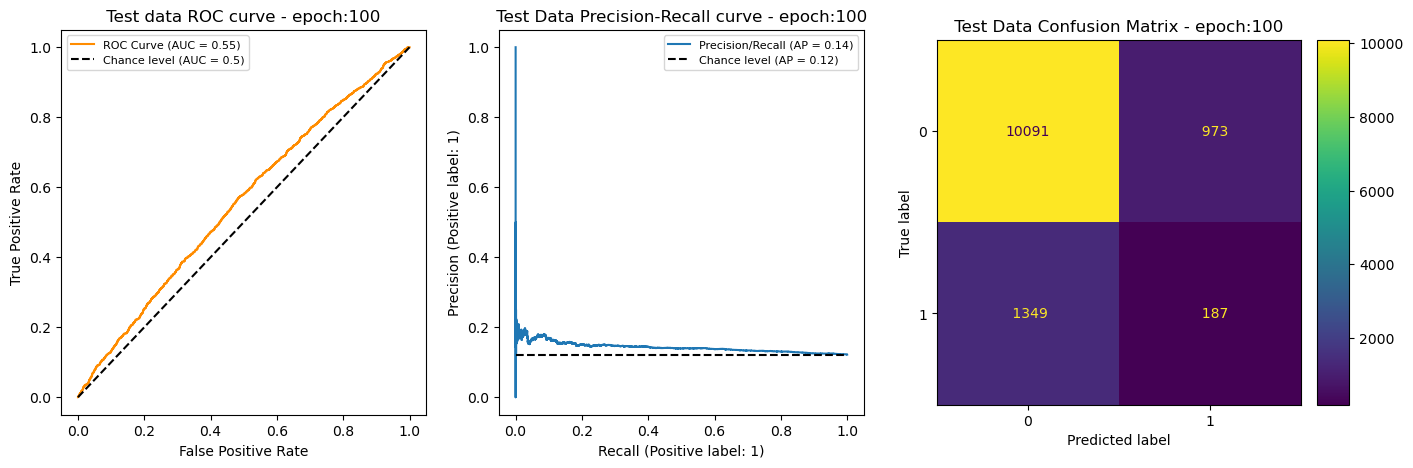

200 Test  Acc : 81.17 %    ROC Auc: 0.5550    PR Auc:0.1278    F1: 0.1486    Prec: 0.1656  Recall: 0.1348    


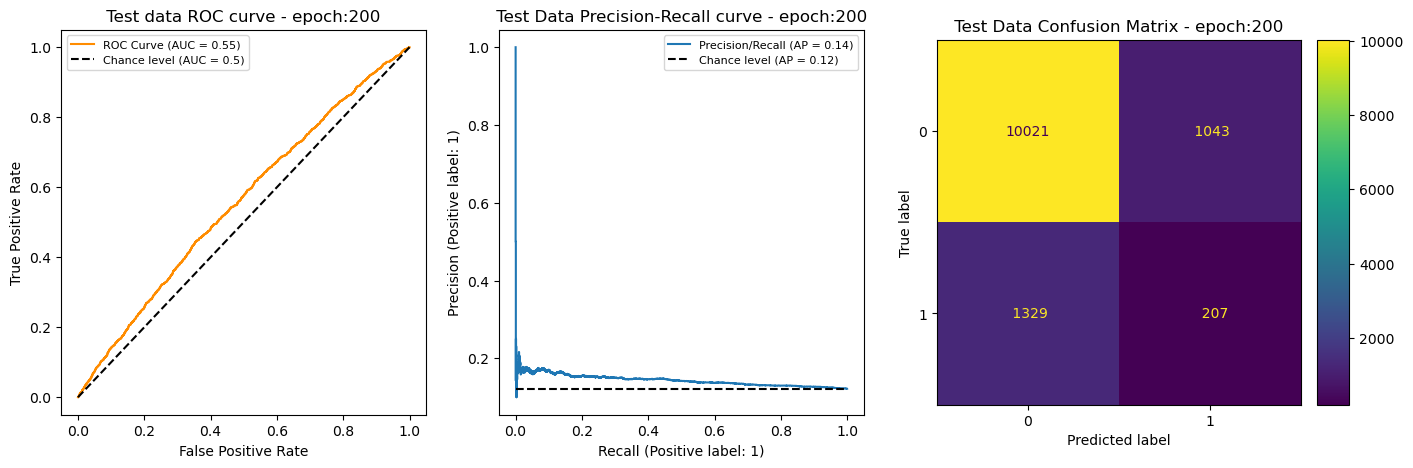

300 Test  Acc : 81.40 %    ROC Auc: 0.5545    PR Auc:0.1291    F1: 0.1545    Prec: 0.1733  Recall: 0.1393    


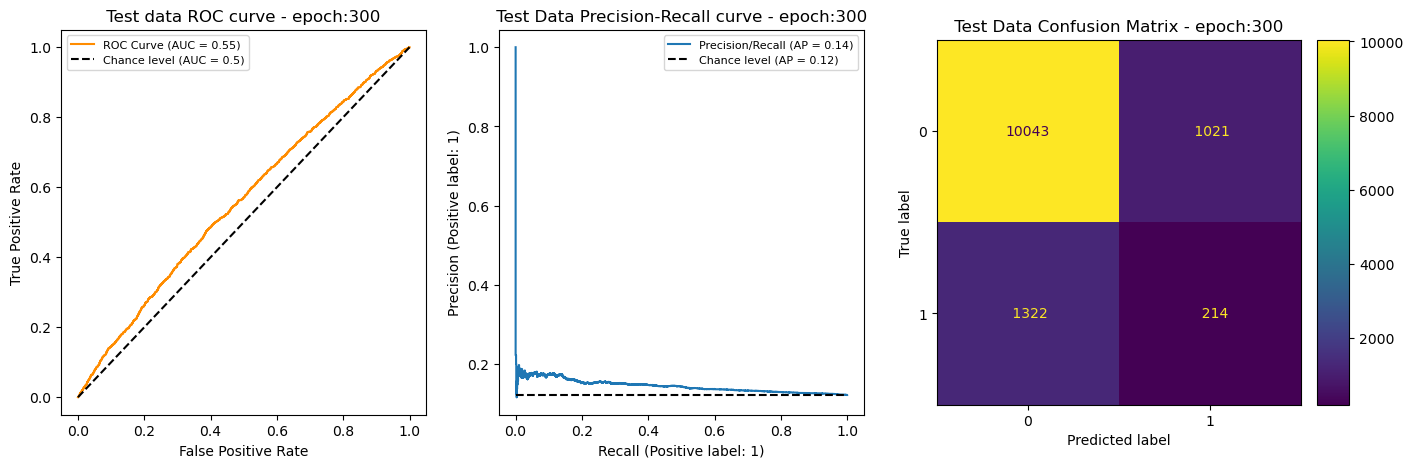

400 Test  Acc : 81.69 %    ROC Auc: 0.5534    PR Auc:0.1290    F1: 0.1521    Prec: 0.1747  Recall: 0.1348    


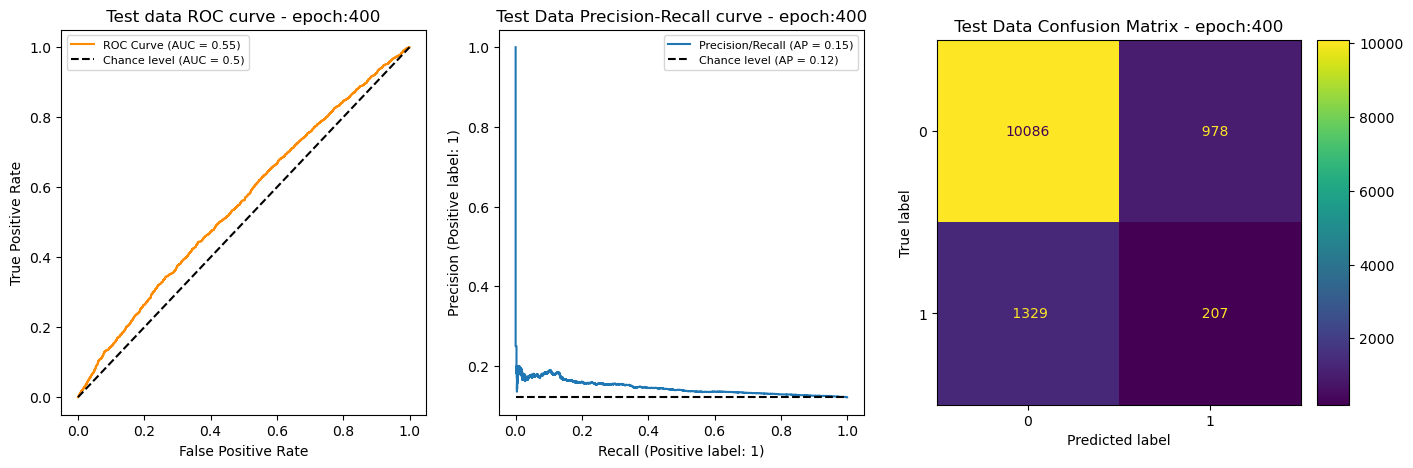

In [18]:
data_type = 'test'
for epoch in [100,200,300,400 ]:
    run_classification_inference(model, CKPT_FILE, epoch, data_loader, data_type, DEVICE)

### t1

In [21]:
plot = False
for ep in [100,200,300, 400]:
    run_classification_inference(model, CKPT_FILE, ep, data_loader, 'test', DEVICE, plot = plot)
    run_classification_inference(model, CKPT_FILE, ep, data_loader, 'val', DEVICE, plot = plot)
    run_classification_inference(model, CKPT_FILE, ep, data_loader, 'train', DEVICE, plot = plot)
    print()

100 Test  Acc : 81.57 %    ROC Auc: 0.5522    PR Auc:0.1267    F1: 0.1387    Prec: 0.1612  Recall: 0.1217    
100 Val   Acc : 81.28 %    ROC Auc: 0.5575    PR Auc:0.1187    F1: 0.1292    Prec: 0.1401  Recall: 0.1199    
100 Train Acc : 97.40 %    ROC Auc: 0.9940    PR Auc:0.8018    F1: 0.8829    Prec: 0.9384  Recall: 0.8337    

200 Test  Acc : 81.17 %    ROC Auc: 0.5550    PR Auc:0.1278    F1: 0.1486    Prec: 0.1656  Recall: 0.1348    
200 Val   Acc : 80.56 %    ROC Auc: 0.5549    PR Auc:0.1196    F1: 0.1400    Prec: 0.1436  Recall: 0.1367    
200 Train Acc : 99.97 %    ROC Auc: 1.0000    PR Auc:0.9976    F1: 0.9986    Prec: 1.0000  Recall: 0.9973    

300 Test  Acc : 81.40 %    ROC Auc: 0.5545    PR Auc:0.1291    F1: 0.1545    Prec: 0.1733  Recall: 0.1393    
300 Val   Acc : 80.67 %    ROC Auc: 0.5549    PR Auc:0.1186    F1: 0.1322    Prec: 0.1377  Recall: 0.1271    
300 Train Acc : 100.00 %    ROC Auc: 1.0000    PR Auc:1.0000    F1: 1.0000    Prec: 1.0000  Recall: 1.0000    

400 Te

### t3 - old

 VAL   Acc : 81.93 % 	 roc_auc: 0.5638 	 Precision: 0.1621 	 Recall: 0.1299 	 F1: 0.1443

 VAL Label counts:  True: [19068  2532] 	 Pred: [19571  2029] 

 VAL Data Classification Report: - epoch:100 

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     19068
           1       0.16      0.13      0.14      2532

    accuracy                           0.82     21600
   macro avg       0.52      0.52      0.52     21600
weighted avg       0.80      0.82      0.81     21600

 VAL   Acc : 81.69 % 	 roc_auc: 0.5623 	 Precision: 0.1541 	 Recall: 0.1252 	 F1: 0.1382

 VAL Label counts:  True: [19068  2532] 	 Pred: [19543  2057] 

 VAL Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     19068
           1       0.15      0.13      0.14      2532

    accuracy                           0.82     21600
   macro avg       0.52      0.52      0.52     21600

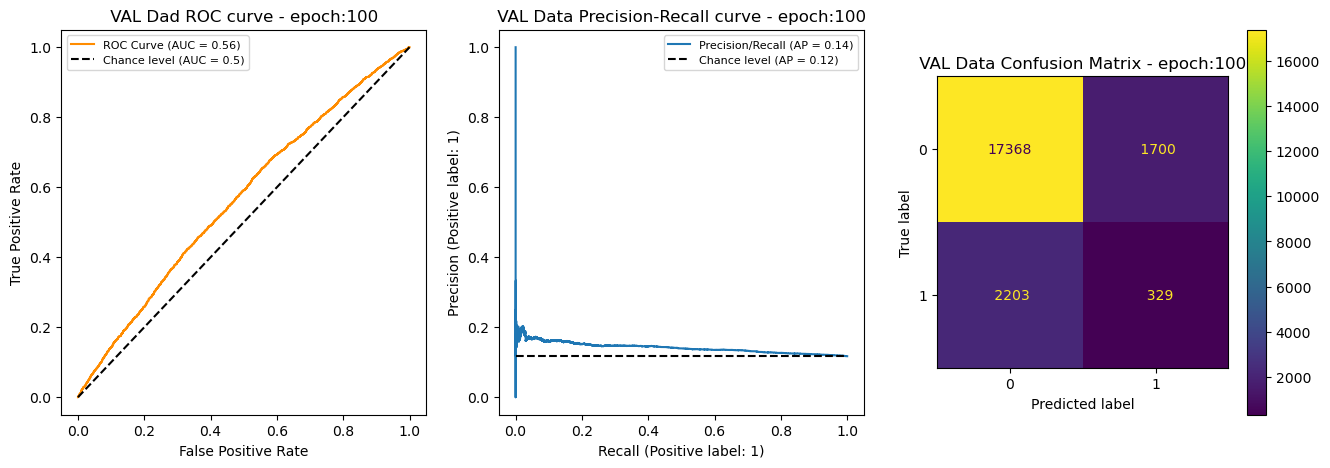

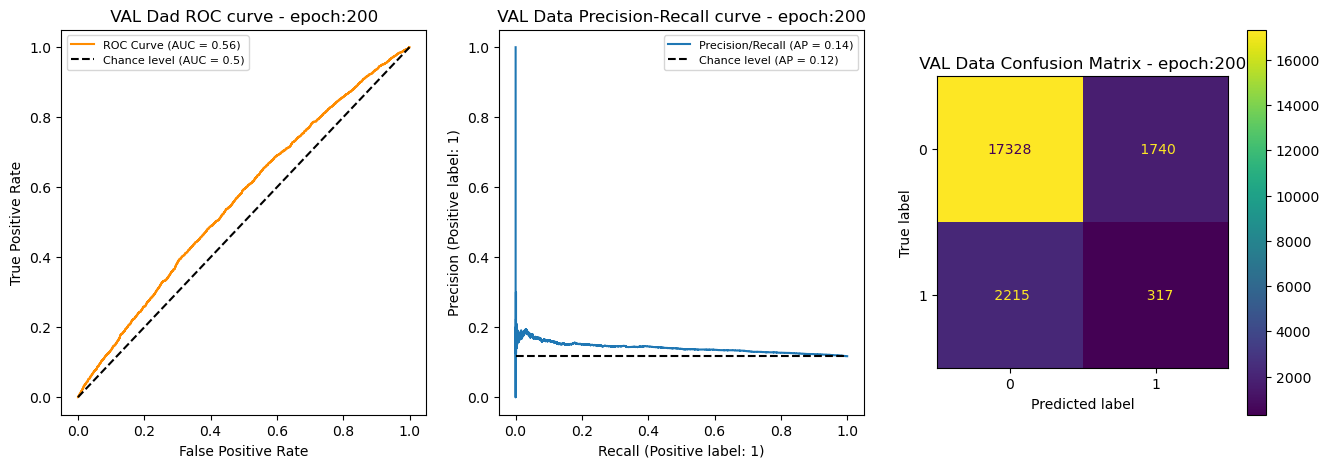

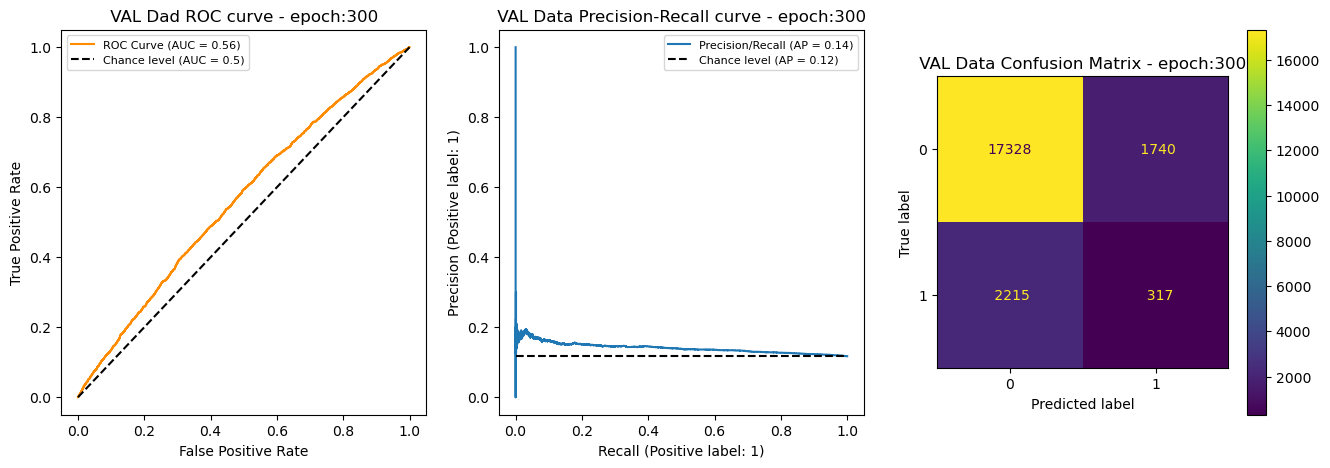

In [56]:
data = 'val'
for ep in [100, 200, 300 ]:
    model, optimizer, scheudler, loaded_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_file.format(ep=ep), ckpt_path = CKPT_PATH)
    _ = model.eval();
    mdl_outputs = run_model_on_test_data(model, data_loader[data], device, title = data, verbose = False)
    mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data,  verbose = True)
    plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )

In [ ]:
print(checkpoint_file)
print(checkpoint_file.format(ep=300))

ep = 200
model, optimizer, scheudler, loaded_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_file.format(ep=ep), ckpt_path = CKPT_PATH)
_ = model.eval()

 TEST  Acc : 83.11 % 	 roc_auc: 0.5665 	 Precision: 0.1656 	 Recall: 0.1385 	 F1: 0.1508

 TEST Label counts:  True: [6420  780] 	 Pred: [6548  652] 

 TEST Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      6420
           1       0.17      0.14      0.15       780

    accuracy                           0.83      7200
   macro avg       0.53      0.53      0.53      7200
weighted avg       0.82      0.83      0.82      7200



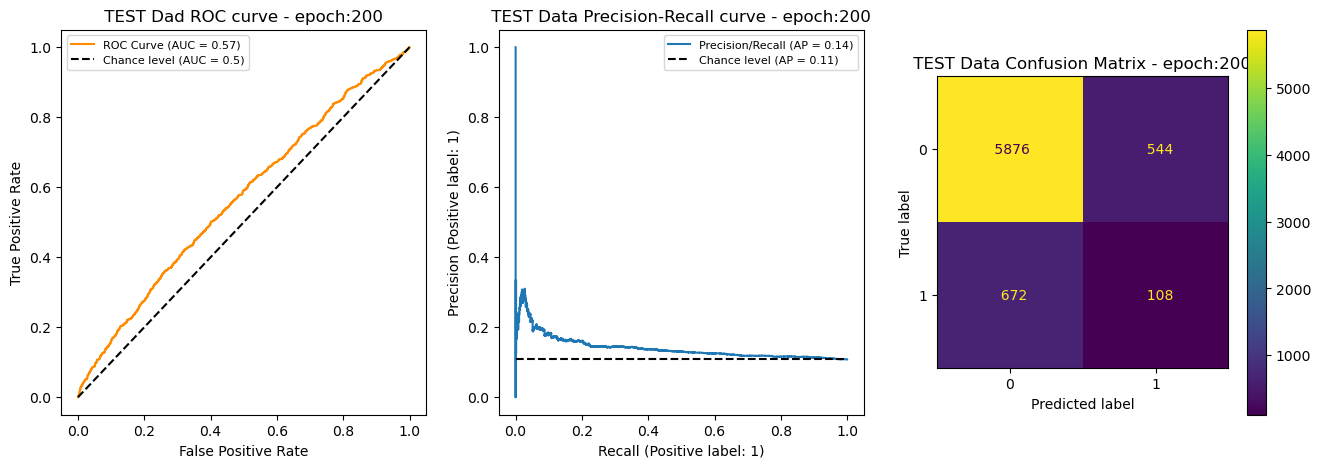

In [59]:
data = 'test'
mdl_outputs = run_model_on_test_data(model, data_loader[data], device, num_batches = 4, title =data, verbose = False)
mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data, verbose = True)
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )

 VAL   Acc : 81.93 % 	 roc_auc: 0.5638 	 Precision: 0.1620 	 Recall: 0.1115 	 F1: 0.1321

 VAL Label counts:  True: [6312  888] 	 Pred: [6589  611] 

 VAL Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6312
           1       0.16      0.11      0.13       888

    accuracy                           0.82      7200
   macro avg       0.52      0.52      0.52      7200
weighted avg       0.79      0.82      0.80      7200



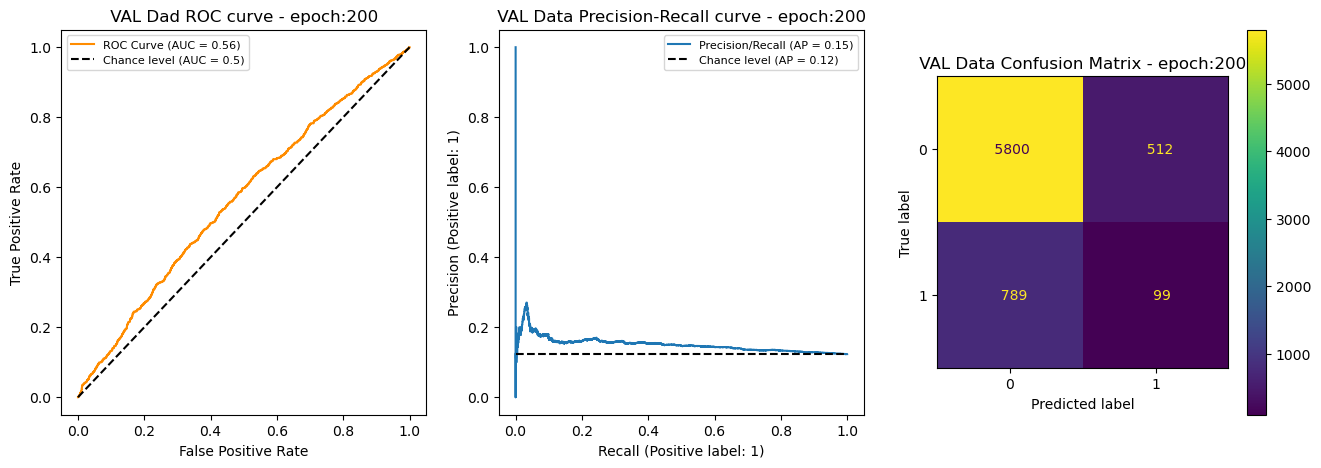

In [60]:
data = 'val'
mdl_outputs = run_model_on_test_data(model, data_loader[data], device, num_batches = 4, title =data, verbose = False)
mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data, verbose = True)
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )

 TRAIN Acc : 99.81 % 	 roc_auc: 1.0000 	 Precision: 0.9988 	 Recall: 0.9844 	 F1: 0.9915

 TRAIN Label counts:  True: [6369  831] 	 Pred: [6381  819] 

 TRAIN Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6369
           1       1.00      0.98      0.99       831

    accuracy                           1.00      7200
   macro avg       1.00      0.99      1.00      7200
weighted avg       1.00      1.00      1.00      7200



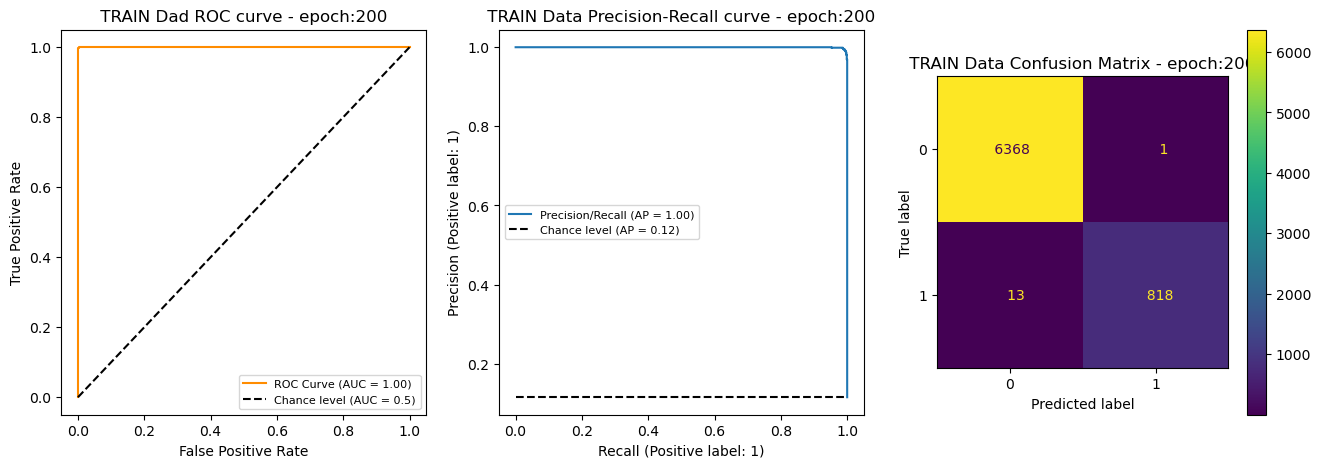

In [61]:
data = 'train'
mdl_outputs = run_model_on_test_data(model, data_loader[data], device, num_batches = 4, title =data, verbose = False)
mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data, verbose = True)
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )
_ = model.train()

# Inference evaluation - (Single 512 Layer, Tanh)

 -  Model: **20240921_0600** - Single layer 512 

In [62]:
# AE_RUNMODE = 'base'
# AE_DATETIME = "20240923_1943"     # Autoencoder training - Baseline, CPB = 600, Latent 250, WD = 0.001 (SNN Factor 0)
# AE_CKPTTYPE = "LAST"
AE_LATENT_DIM = 1471
RUN_DATETIME = '20240921_0600'

input_num_cols = AE_LATENT_DIM + len(METADATA_COLS)

MODEL_TYPE = 'single_layer'
n_input    = AE_LATENT_DIM  # the embedding dimensionality 
 
n_hidden_1 = 512  # the number of neurons in the hidden layer of the MLP
n_hidden_2 = 512  # the number of neurons in the hidden layer of the MLP
n_hidden_3 = 128

CKPT_FILE_BASE = f"NN_{input_num_cols}profiles_cpb{COMPOUNDS_PER_BATCH}_{RUN_DATETIME}_ep_{{ep}}"
CKPT_FILE = os.path.join(CKPT_PATH, CKPT_FILE_BASE )
print(CKPT_FILE)
print(CKPT_FILE.format(ep=999))
print()


./saved_models/profile_models/NN_1482profiles_cpb600_20240921_0600_ep_{ep}
./saved_models/profile_models/NN_1482profiles_cpb600_20240921_0600_ep_999



In [63]:
# data_loader = define_inference_datasets(cellpainting_args, AE_RUNMODE, AE_DATETIME, input_num_cols, AE_CKPTTYPE, INPUT_PATH)
model = build_model(MODEL_TYPE, input = n_input, hidden_1 = n_hidden_1, hidden_2 = n_hidden_2, hidden_3=n_hidden_3, device =DEVICE)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Mult-Adds                 Trainable
Sequential                               [30, 1471]                [30, 1]                   --                             --                   --                        True
├─Linear: 1-1                            [30, 1471]                [30, 512]                 753,664                    99.93%                   22,609,920                True
│    └─weight                                                                                ├─753,152
│    └─bias                                                                                  └─512
├─Tanh: 1-2                              [30, 512]                 [30, 512]                 --                             --                   --                        --
├─Linear: 1-3                            [30, 512]                 [30, 1]                 

In [25]:
# checkpoint_file = f"NN_1482profiles_{ae_datetime}_{ae_ckpttype}_{RUN_DATETIME}_ep_{{ep}}"
# print(checkpoint_file.format(ep = 100))

### t0

./saved_models/profile_models/NN_1482profiles_cpb600_20240921_0600_ep_100
 Val   Acc : 83.69 % 	 roc_auc: 0.5589 	 Precision: 0.1608 	 Recall: 0.1055 	 F1: 0.1274

 Val Label counts:  True: [11178  1422] 	 Pred: [11667   933] 

 Val Data Classification Report: - epoch:100 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11178
           1       0.16      0.11      0.13      1422

    accuracy                           0.84     12600
   macro avg       0.53      0.52      0.52     12600
weighted avg       0.81      0.84      0.82     12600



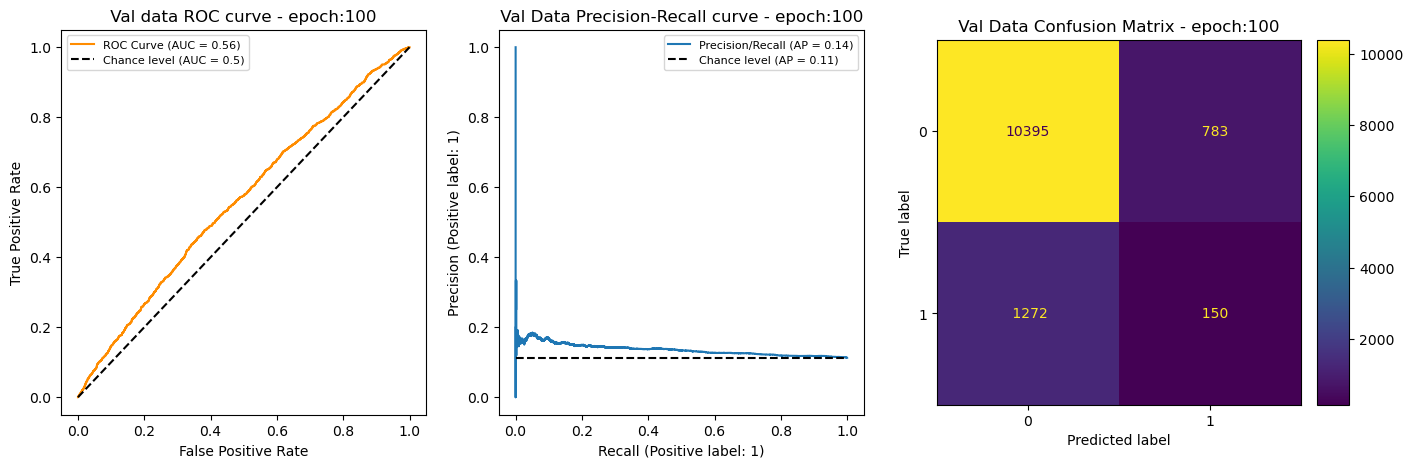

./saved_models/profile_models/NN_1482profiles_cpb600_20240921_0600_ep_200
 Val   Acc : 83.75 % 	 roc_auc: 0.5657 	 Precision: 0.1679 	 Recall: 0.1111 	 F1: 0.1337

 Val Label counts:  True: [11178  1422] 	 Pred: [11659   941] 

 Val Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11178
           1       0.17      0.11      0.13      1422

    accuracy                           0.84     12600
   macro avg       0.53      0.52      0.52     12600
weighted avg       0.81      0.84      0.82     12600



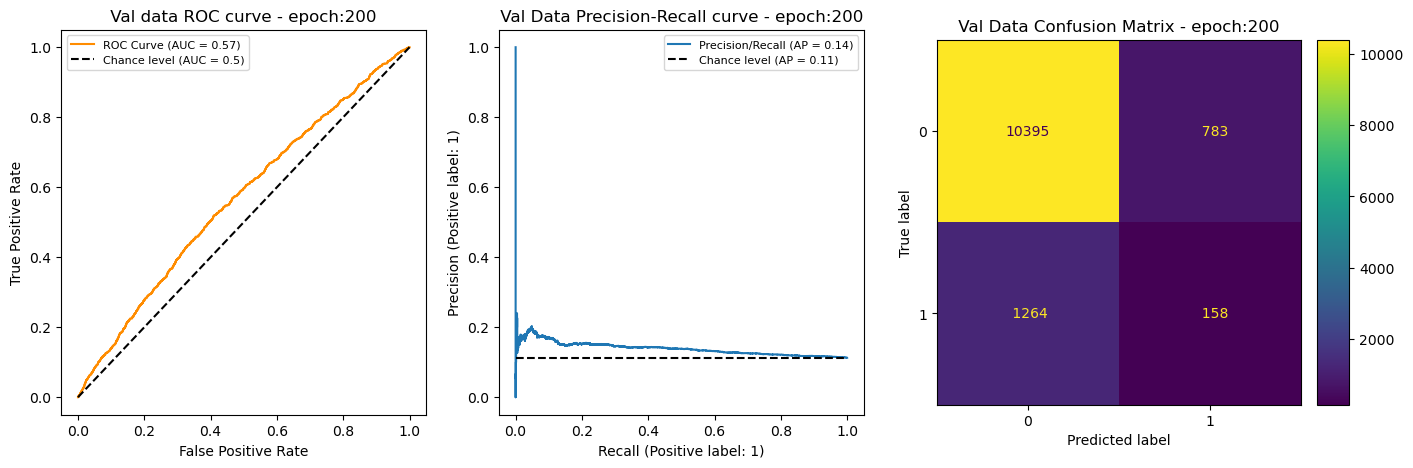

./saved_models/profile_models/NN_1482profiles_cpb600_20240921_0600_ep_300
 Val   Acc : 83.70 % 	 roc_auc: 0.5657 	 Precision: 0.1645 	 Recall: 0.1090 	 F1: 0.1311

 Val Label counts:  True: [11178  1422] 	 Pred: [11658   942] 

 Val Data Classification Report: - epoch:300 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11178
           1       0.16      0.11      0.13      1422

    accuracy                           0.84     12600
   macro avg       0.53      0.52      0.52     12600
weighted avg       0.81      0.84      0.82     12600



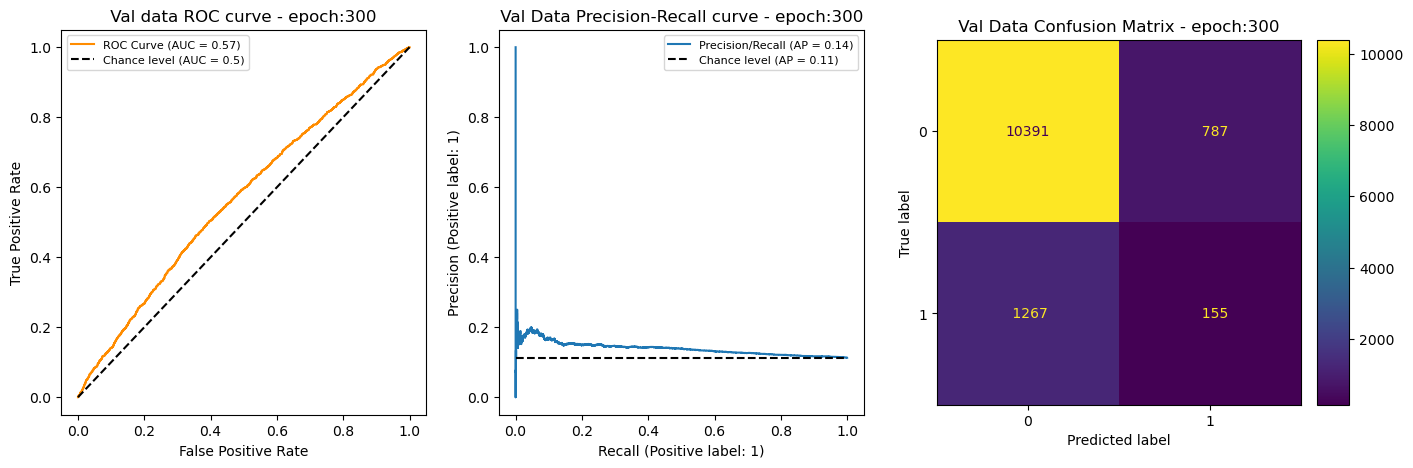

./saved_models/profile_models/NN_1482profiles_cpb600_20240921_0600_ep_400
 Val   Acc : 83.72 % 	 roc_auc: 0.5656 	 Precision: 0.1644 	 Recall: 0.1083 	 F1: 0.1306

 Val Label counts:  True: [11178  1422] 	 Pred: [11663   937] 

 Val Data Classification Report: - epoch:400 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11178
           1       0.16      0.11      0.13      1422

    accuracy                           0.84     12600
   macro avg       0.53      0.52      0.52     12600
weighted avg       0.81      0.84      0.82     12600



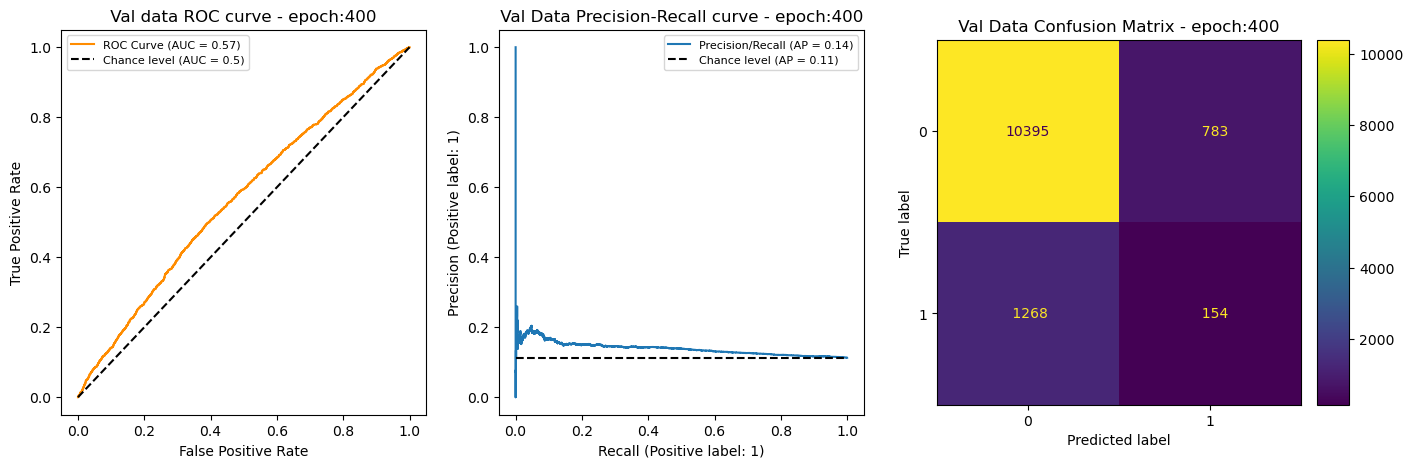

In [67]:
data_type = 'val'
for epoch in [100,200,300,400 ]:
    run_classification_inference(model, CKPT_FILE, epoch, data_loader, data_type, DEVICE)

### t1

./saved_models/profile_models/NN_1482profiles_cpb600_20240921_0600_ep_400
400 Test  Acc : 83.82 %    ROC Auc: 0.5761    PR Auc:0.1275    F1: 0.1275    Prec: 0.1645  Recall: 0.1041    

 Test Label counts:  True: [11169  1431] 	 Pred: [11694   906] 

 Test Data Classification Report: - epoch:400 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11169
           1       0.16      0.10      0.13      1431

    accuracy                           0.84     12600
   macro avg       0.53      0.52      0.52     12600
weighted avg       0.81      0.84      0.82     12600



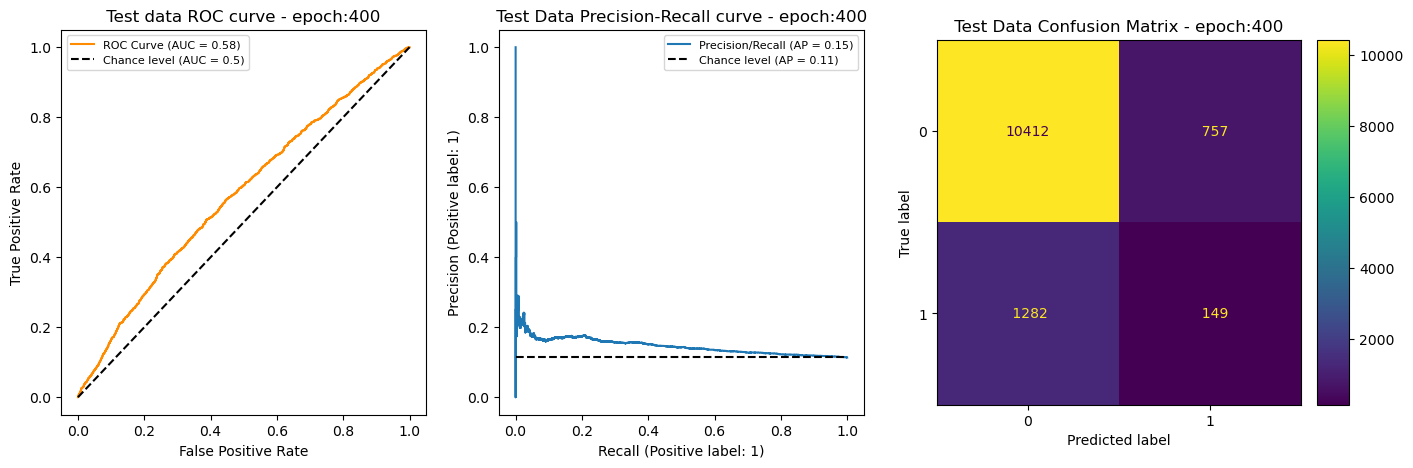

./saved_models/profile_models/NN_1482profiles_cpb600_20240921_0600_ep_400
400 Val   Acc : 83.72 %    ROC Auc: 0.5656    PR Auc:0.1306    F1: 0.1306    Prec: 0.1644  Recall: 0.1083    

 Val Label counts:  True: [11178  1422] 	 Pred: [11663   937] 

 Val Data Classification Report: - epoch:400 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11178
           1       0.16      0.11      0.13      1422

    accuracy                           0.84     12600
   macro avg       0.53      0.52      0.52     12600
weighted avg       0.81      0.84      0.82     12600



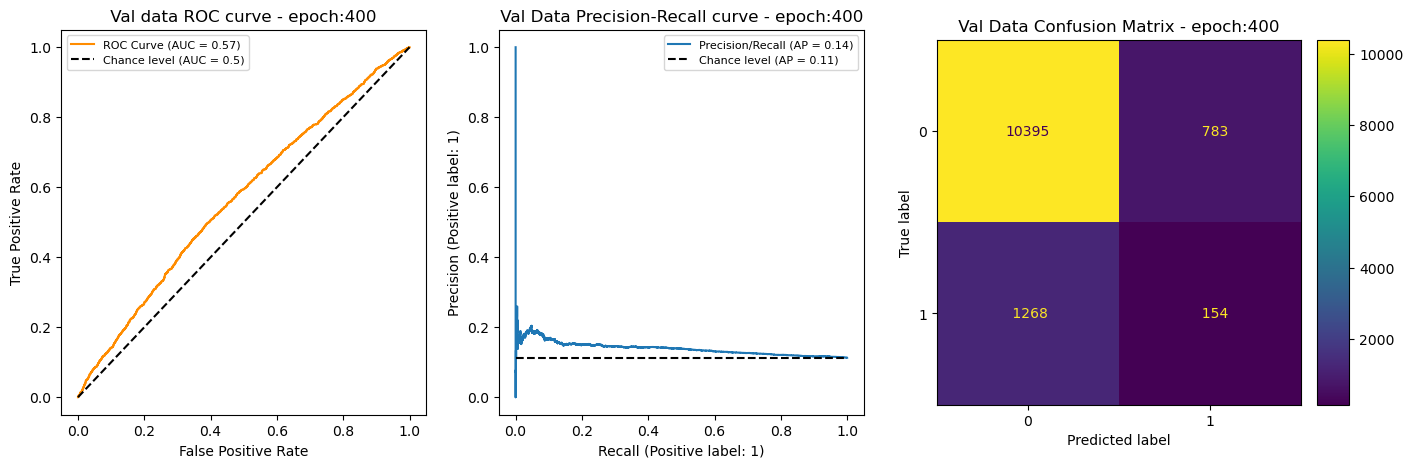

./saved_models/profile_models/NN_1482profiles_cpb600_20240921_0600_ep_400
400 Train Acc : 100.00 %    ROC Auc: 1.0000    PR Auc:1.0000    F1: 1.0000    Prec: 1.0000  Recall: 1.0000    

 Train Label counts:  True: [11121  1479] 	 Pred: [11121  1479] 

 Train Data Classification Report: - epoch:400 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11121
           1       1.00      1.00      1.00      1479

    accuracy                           1.00     12600
   macro avg       1.00      1.00      1.00     12600
weighted avg       1.00      1.00      1.00     12600



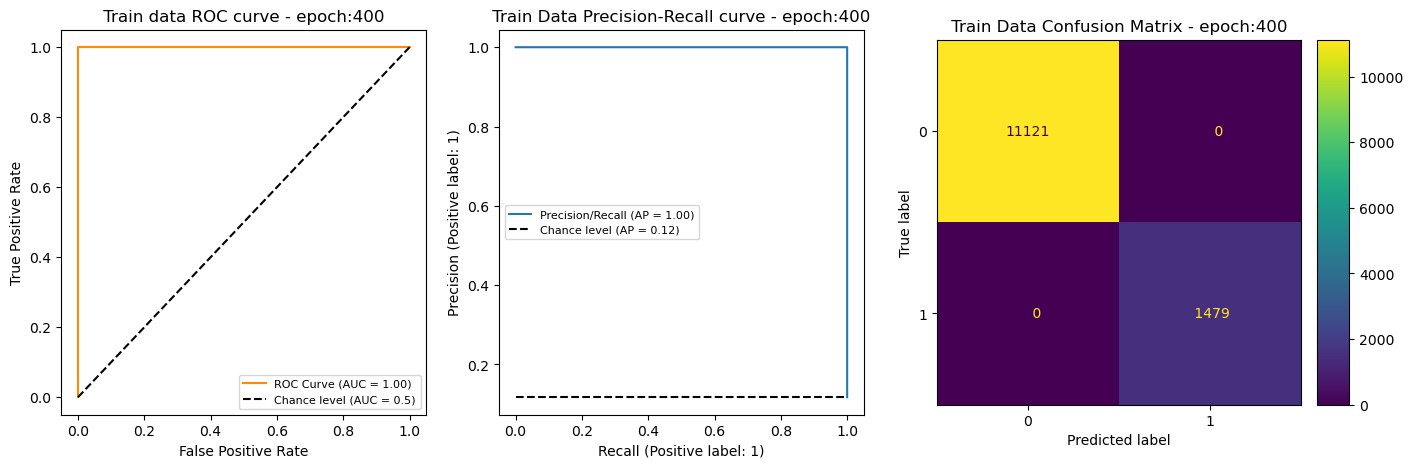

In [67]:
ep = 400
run_classification_inference(model, CKPT_FILE, ep, data_loader, 'test', DEVICE)
run_classification_inference(model, CKPT_FILE, ep, data_loader, 'val', DEVICE)
run_classification_inference(model, CKPT_FILE, ep, data_loader, 'train', DEVICE)

# Inference evaluation - (ReLU 256/256/128)

In [14]:
AE_LATENT_DIM = 1471
# RUN_DATETIME = '20240912_0400'
RUN_DATETIME = '20240912_0401'

input_num_cols = AE_LATENT_DIM + len(METADATA_COLS)

MODEL_TYPE = 'relu'
n_input    = AE_LATENT_DIM  # the embedding dimensionality 
 
n_hidden_1 = 256  # the number of neurons in the hidden layer of the MLP
n_hidden_2 = 256  # the number of neurons in the hidden layer of the MLP
n_hidden_3 = 128

CKPT_FILE_BASE = f"NN_{input_num_cols}profiles_cpb{COMPOUNDS_PER_BATCH}_{RUN_DATETIME}_ep_{{ep}}"
CKPT_FILE = os.path.join(CKPT_PATH, CKPT_FILE_BASE )
print(CKPT_FILE)
print(CKPT_FILE.format(ep=999))
print()


./saved_models/profile_models/NN_1482profiles_cpb600_20240912_0401_ep_{ep}
./saved_models/profile_models/NN_1482profiles_cpb600_20240912_0401_ep_999



In [15]:
# data_loader = define_inference_datasets(cellpainting_args, AE_RUNMODE, AE_DATETIME, input_num_cols, AE_CKPTTYPE, INPUT_PATH)
model = build_model(MODEL_TYPE, input = n_input, hidden_1 = n_hidden_1, hidden_2 = n_hidden_2, hidden_3=n_hidden_3, device =DEVICE)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Mult-Adds                 Trainable
Sequential                               [30, 1471]                [30, 1]                   --                             --                   --                        True
├─Linear: 1-1                            [30, 1471]                [30, 256]                 376,832                    79.22%                   11,304,960                True
│    └─weight                                                                                ├─376,576
│    └─bias                                                                                  └─256
├─ReLU: 1-2                              [30, 256]                 [30, 256]                 --                             --                   --                        --
├─Linear: 1-3                            [30, 256]                 [30, 256]               

In [16]:
checkpoint_file = CKPT_FILE.format(ep=100)
print(checkpoint_file)

./saved_models/profile_models/NN_1482profiles_cpb600_20240912_0401_ep_100


### t0

./saved_models/profile_models/NN_1482profiles_cpb600_20240912_0400_ep_100
 Test  Acc : 88.21 % 	 roc_auc: 0.5662 	 Precision: 0.3248 	 Recall: 0.0356 	 F1: 0.0642

 Test Label counts:  True: [11169  1431] 	 Pred: [12443   157] 

 Test Data Classification Report: - epoch:100 

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     11169
           1       0.32      0.04      0.06      1431

    accuracy                           0.88     12600
   macro avg       0.61      0.51      0.50     12600
weighted avg       0.83      0.88      0.84     12600



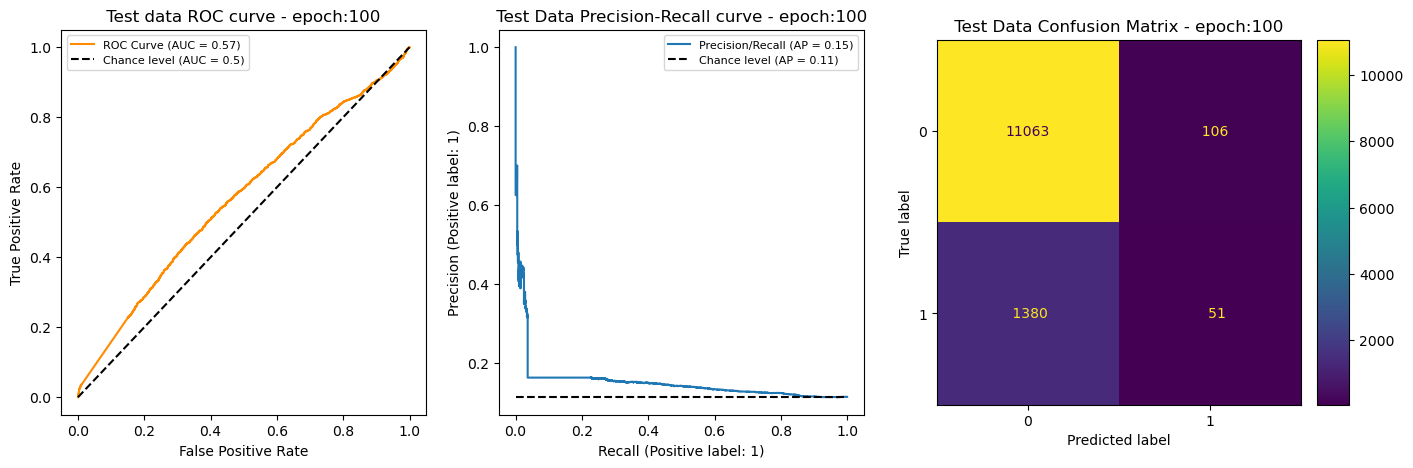

./saved_models/profile_models/NN_1482profiles_cpb600_20240912_0400_ep_200
 Test  Acc : 88.21 % 	 roc_auc: 0.5662 	 Precision: 0.3248 	 Recall: 0.0356 	 F1: 0.0642

 Test Label counts:  True: [11169  1431] 	 Pred: [12443   157] 

 Test Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     11169
           1       0.32      0.04      0.06      1431

    accuracy                           0.88     12600
   macro avg       0.61      0.51      0.50     12600
weighted avg       0.83      0.88      0.84     12600



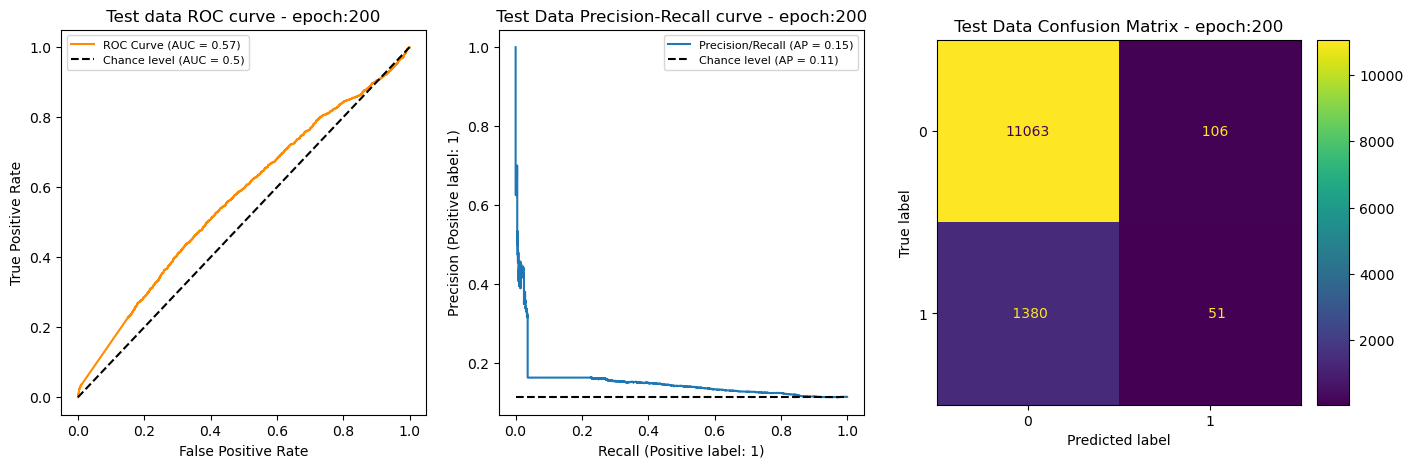

./saved_models/profile_models/NN_1482profiles_cpb600_20240912_0400_ep_300
 Test  Acc : 88.21 % 	 roc_auc: 0.5662 	 Precision: 0.3248 	 Recall: 0.0356 	 F1: 0.0642

 Test Label counts:  True: [11169  1431] 	 Pred: [12443   157] 

 Test Data Classification Report: - epoch:300 

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     11169
           1       0.32      0.04      0.06      1431

    accuracy                           0.88     12600
   macro avg       0.61      0.51      0.50     12600
weighted avg       0.83      0.88      0.84     12600



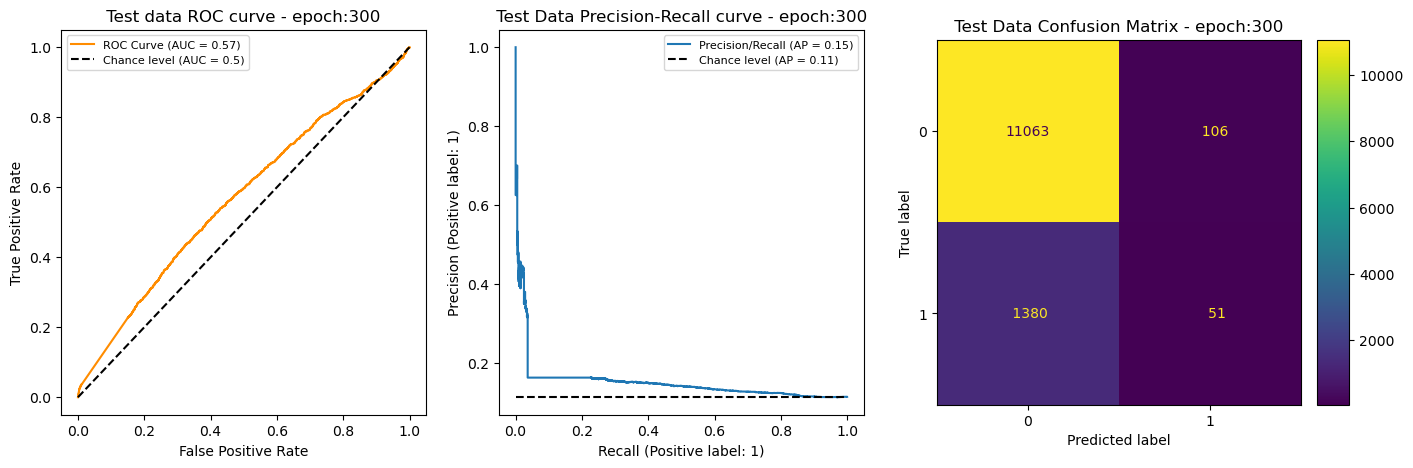

In [48]:
data_type = 'test'
for epoch in [100,200,300]:
    run_classification_inference(model, CKPT_FILE, epoch, data_loader, data_type, DEVICE)

### t1

In [18]:
for ep in [200,300,400,500]:
    run_classification_inference(model, CKPT_FILE, ep, data_loader, 'test', DEVICE)
    run_classification_inference(model, CKPT_FILE, ep, data_loader, 'val', DEVICE)
    run_classification_inference(model, CKPT_FILE, ep, data_loader, 'train', DEVICE)
    print()

FileNotFound Exception - ./saved_models/profile_models/NN_1482profiles_cpb600_20240912_0401_ep_200.pt


UnboundLocalError: cannot access local variable 'checkpoint' where it is not associated with a value

### t3 old

 TEST  Acc : 88.21 % 	 roc_auc: 0.5662 	 Precision: 0.3248 	 Recall: 0.0356 	 F1: 0.0642

 TEST Label counts:  True: [11169  1431] 	 Pred: [12443   157] 

 TEST Data Classification Report: - epoch:100 

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     11169
           1       0.32      0.04      0.06      1431

    accuracy                           0.88     12600
   macro avg       0.61      0.51      0.50     12600
weighted avg       0.83      0.88      0.84     12600



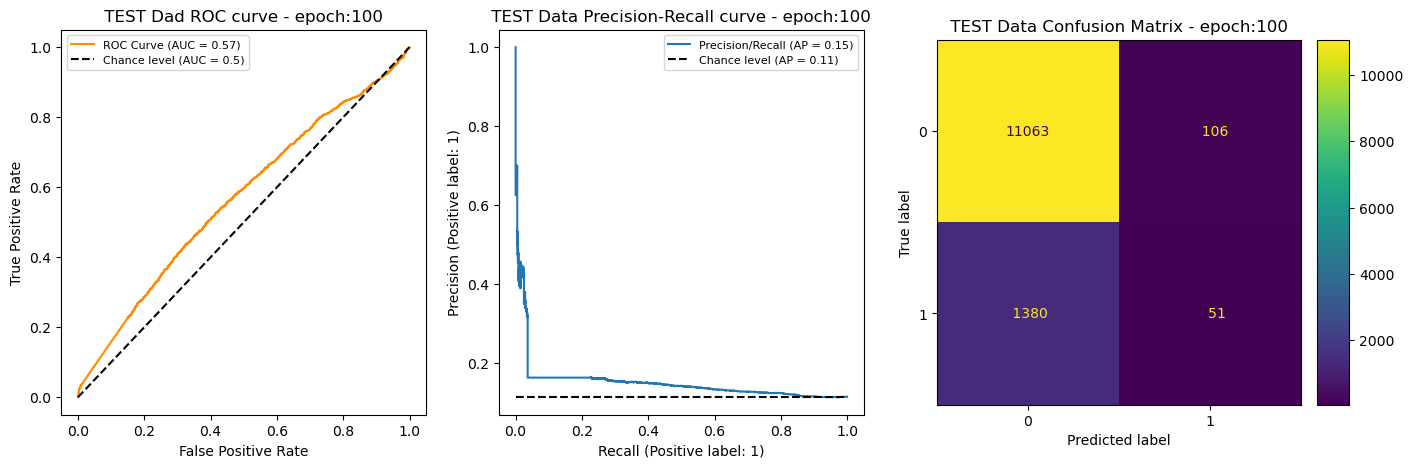

 TEST  Acc : 88.21 % 	 roc_auc: 0.5662 	 Precision: 0.3248 	 Recall: 0.0356 	 F1: 0.0642

 TEST Label counts:  True: [11169  1431] 	 Pred: [12443   157] 

 TEST Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     11169
           1       0.32      0.04      0.06      1431

    accuracy                           0.88     12600
   macro avg       0.61      0.51      0.50     12600
weighted avg       0.83      0.88      0.84     12600



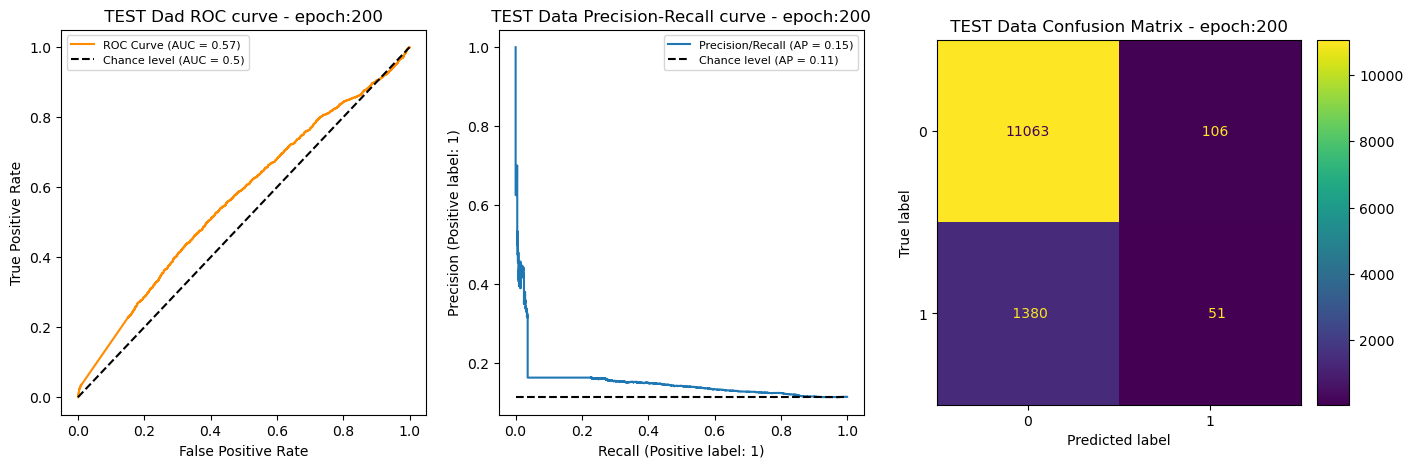

 TEST  Acc : 88.21 % 	 roc_auc: 0.5662 	 Precision: 0.3248 	 Recall: 0.0356 	 F1: 0.0642

 TEST Label counts:  True: [11169  1431] 	 Pred: [12443   157] 

 TEST Data Classification Report: - epoch:300 

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     11169
           1       0.32      0.04      0.06      1431

    accuracy                           0.88     12600
   macro avg       0.61      0.51      0.50     12600
weighted avg       0.83      0.88      0.84     12600



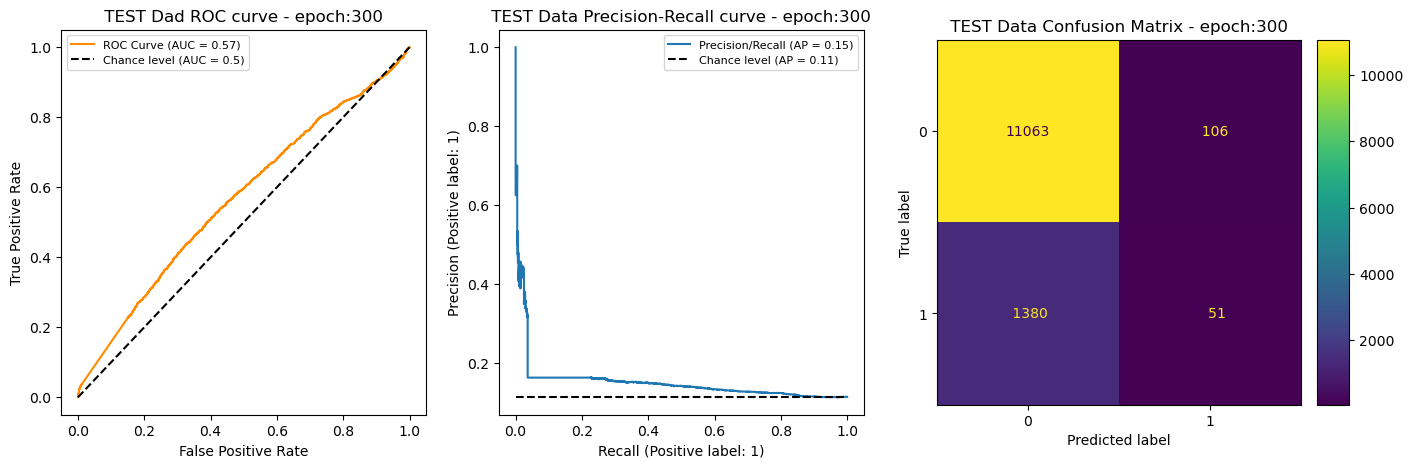

In [23]:
data = 'test'
for ep in [100, 200, 300 ]:
    model, optimizer, scheudler, loaded_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_file.format(ep=ep), ckpt_path = CKPT_PATH)
    _ = model.eval();
    model = model.to(device)
    mdl_outputs = run_model_on_test_data(model, data_loader[data], device, title = data, verbose = False)
    mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data,  verbose = True)
    plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )
    plt.show()

In [ ]:
print(checkpoint_file)
print(checkpoint_file.format(ep=200))
ep = 200
model, optimizer, scheudler, loaded_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_file.format(ep=ep), ckpt_path = CKPT_PATH)
_ = model.eval()
model = model.to(device)

 TEST  Acc : 88.78 % 	 roc_auc: 0.5622 	 Precision: 0.3444 	 Recall: 0.0397 	 F1: 0.0713

 TEST Label counts:  True: [6420  780] 	 Pred: [7110   90] 

 TEST Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      6420
           1       0.34      0.04      0.07       780

    accuracy                           0.89      7200
   macro avg       0.62      0.52      0.51      7200
weighted avg       0.84      0.89      0.85      7200



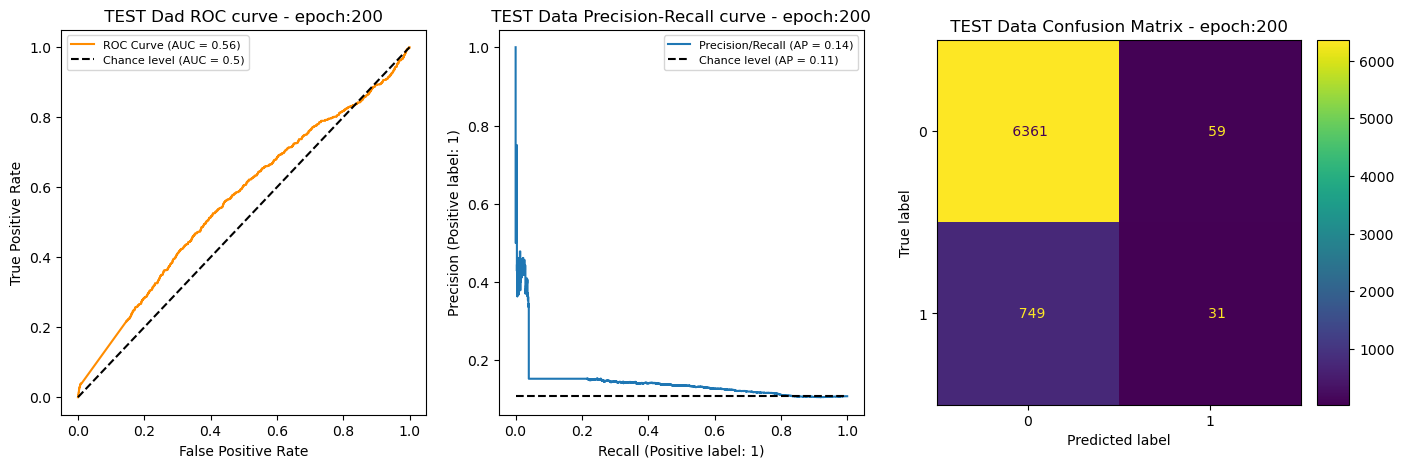

In [26]:
data = 'test'
mdl_outputs = run_model_on_test_data(model, data_loader[data], device, num_batches = 4, title =data, verbose = False)
mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data, verbose = True)
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )

 VAL   Acc : 87.26 % 	 roc_auc: 0.5791 	 Precision: 0.3645 	 Recall: 0.0439 	 F1: 0.0784

 VAL Label counts:  True: [6312  888] 	 Pred: [7093  107] 

 VAL Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      6312
           1       0.36      0.04      0.08       888

    accuracy                           0.87      7200
   macro avg       0.62      0.52      0.50      7200
weighted avg       0.82      0.87      0.83      7200



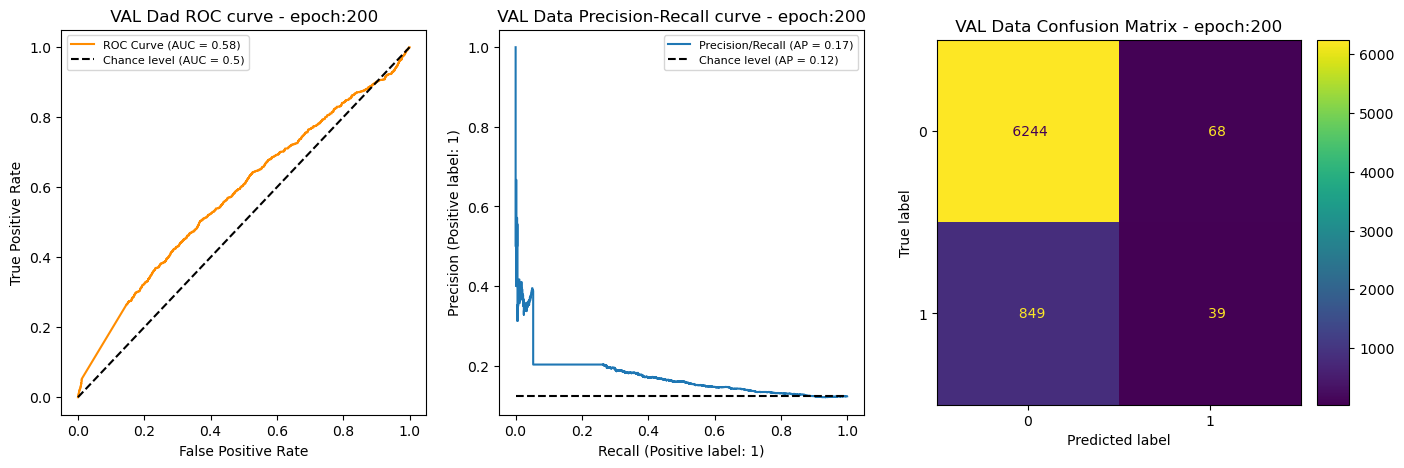

In [27]:
data = 'val'
mdl_outputs = run_model_on_test_data(model, data_loader[data], device, num_batches = 4, title =data, verbose = False)
mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data, verbose = True)
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )

 TRAIN Acc : 90.42 % 	 roc_auc: 0.8355 	 Precision: 0.9862 	 Recall: 0.1721 	 F1: 0.2930

 TRAIN Label counts:  True: [6369  831] 	 Pred: [7055  145] 

 TRAIN Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      6369
           1       0.99      0.17      0.29       831

    accuracy                           0.90      7200
   macro avg       0.94      0.59      0.62      7200
weighted avg       0.91      0.90      0.87      7200



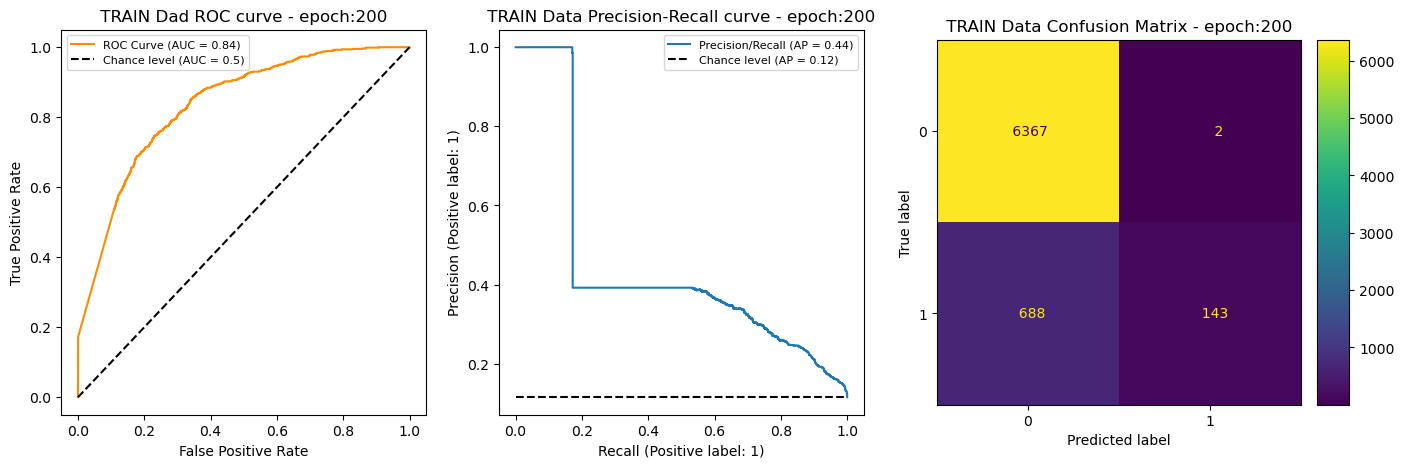

In [28]:
data = 'train'
mdl_outputs = run_model_on_test_data(model, data_loader[data], device, num_batches = 4, title =data, verbose = False)
mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data, verbose = True)
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )
_ = model.train()

# Inference evaluation - (Batch Norm 256/256/128)

 - Model : **20240913_0700** - 4 layer with Batch Norm and ReLU nonlinearity

In [37]:
AE_LATENT_DIM = 1471
RUN_DATETIME = '20240913_0700'

input_num_cols = AE_LATENT_DIM + len(METADATA_COLS)

MODEL_TYPE = 'batch_norm'
n_input    = AE_LATENT_DIM  # the embedding dimensionality 
 
n_hidden_1 = 256  # the number of neurons in the hidden layer of the MLP
n_hidden_2 = 256  # the number of neurons in the hidden layer of the MLP
n_hidden_3 = 128

CKPT_FILE_BASE = f"NN_{input_num_cols}profiles_cpb{COMPOUNDS_PER_BATCH}_{RUN_DATETIME}_ep_{{ep}}"
CKPT_FILE = os.path.join(CKPT_PATH, CKPT_FILE_BASE )
print(CKPT_FILE)
print(CKPT_FILE.format(ep=999))
print()


./saved_models/profile_models/NN_1482profiles_cpb600_20240913_0700_ep_{ep}
./saved_models/profile_models/NN_1482profiles_cpb600_20240913_0700_ep_999



In [38]:
# data_loader = define_inference_datasets(cellpainting_args, AE_RUNMODE, AE_DATETIME, input_num_cols, AE_CKPTTYPE, INPUT_PATH)
model = build_model(MODEL_TYPE, input = n_input, hidden_1 = n_hidden_1, hidden_2 = n_hidden_2, hidden_3=n_hidden_3, device =DEVICE)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Mult-Adds                 Trainable
Sequential                               [30, 1471]                [30, 1]                   --                             --                   --                        True
├─Linear: 1-1                            [30, 1471]                [30, 256]                 376,832                    79.01%                   11,304,960                True
│    └─weight                                                                                ├─376,576
│    └─bias                                                                                  └─256
├─BatchNorm1d: 1-2                       [30, 256]                 [30, 256]                 512                         0.11%                   15,360                    True
│    └─weight                                                                            

### t0

./saved_models/profile_models/NN_1482profiles_cpb600_20240913_0700_ep_100
 Val   Acc : 81.84 %    ROC Auc: 0.5428    PR Auc:0.1398    F1: 0.1398    Prec: 0.1502  Recall: 0.1308    

 Val Label counts:  True: [11178  1422] 	 Pred: [11362  1238] 

 Val Data Classification Report: - epoch:100 

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     11178
           1       0.15      0.13      0.14      1422

    accuracy                           0.82     12600
   macro avg       0.52      0.52      0.52     12600
weighted avg       0.81      0.82      0.81     12600



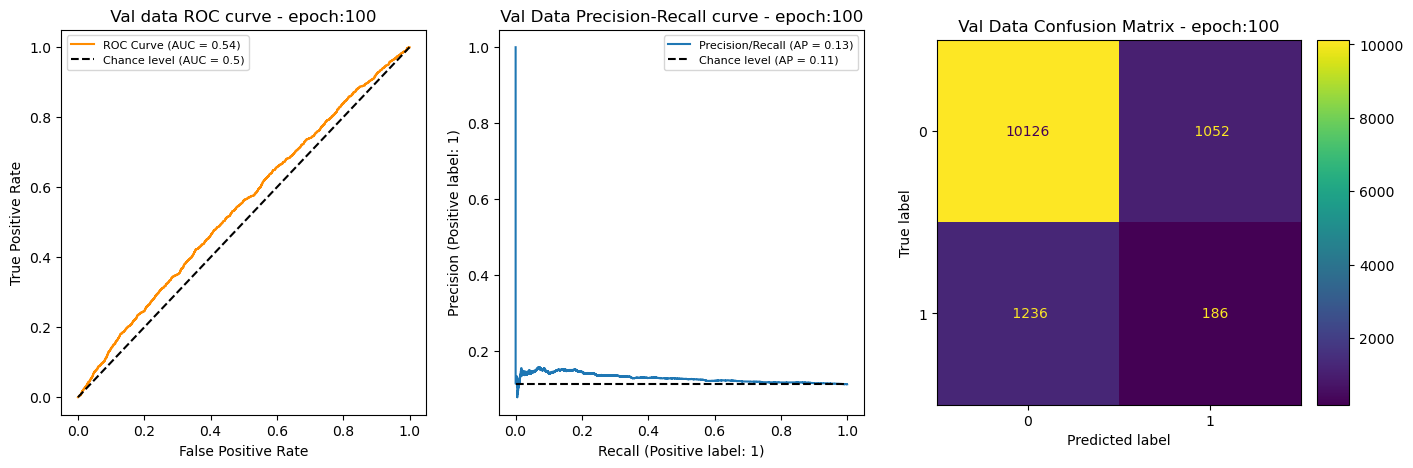

./saved_models/profile_models/NN_1482profiles_cpb600_20240913_0700_ep_200
 Val   Acc : 81.36 %    ROC Auc: 0.5408    PR Auc:0.1467    F1: 0.1467    Prec: 0.1518  Recall: 0.1421    

 Val Label counts:  True: [11178  1422] 	 Pred: [11269  1331] 

 Val Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.89      0.90      0.90     11178
           1       0.15      0.14      0.15      1422

    accuracy                           0.81     12600
   macro avg       0.52      0.52      0.52     12600
weighted avg       0.81      0.81      0.81     12600



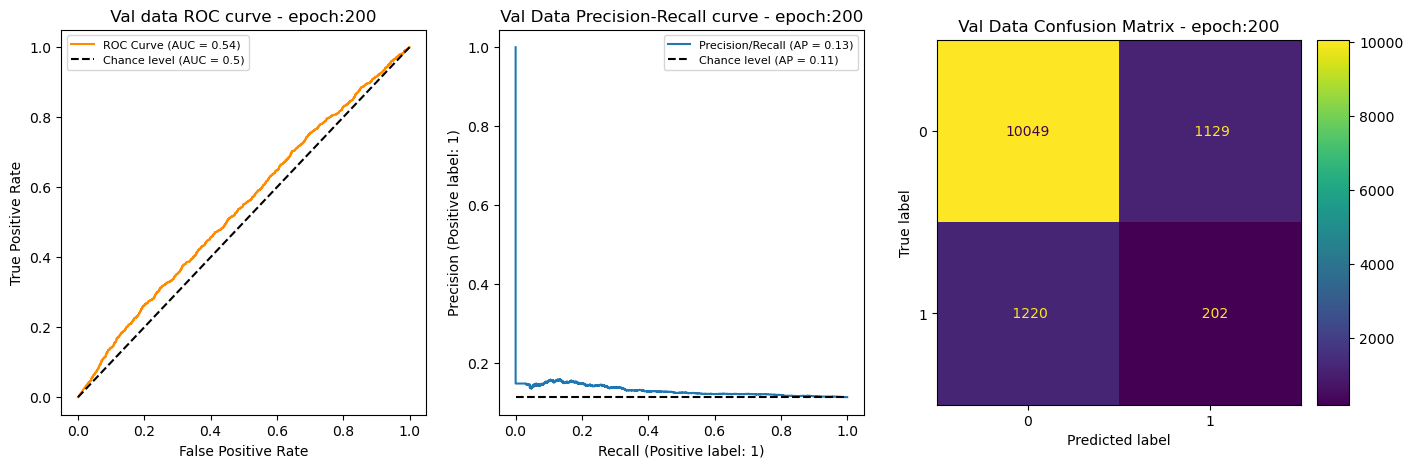

./saved_models/profile_models/NN_1482profiles_cpb600_20240913_0700_ep_300
 Val   Acc : 81.17 %    ROC Auc: 0.5399    PR Auc:0.1473    F1: 0.1473    Prec: 0.1506  Recall: 0.1442    

 Val Label counts:  True: [11178  1422] 	 Pred: [11239  1361] 

 Val Data Classification Report: - epoch:300 

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     11178
           1       0.15      0.14      0.15      1422

    accuracy                           0.81     12600
   macro avg       0.52      0.52      0.52     12600
weighted avg       0.81      0.81      0.81     12600



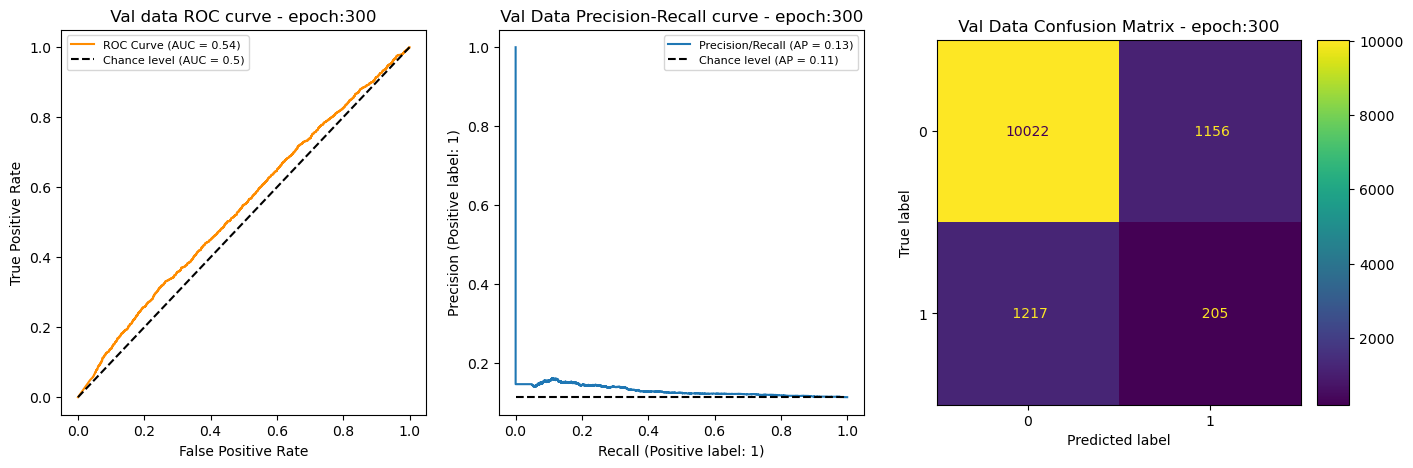

In [39]:
data_type = 'val'
for epoch in [100,200,300 ]:
    run_classification_inference(model, CKPT_FILE, epoch, data_loader, data_type, DEVICE)

### t1

./saved_models/profile_models/NN_1482profiles_cpb600_20240913_0700_ep_100
 Test  Acc : 81.60 %    ROC Auc: 0.5625    PR Auc:0.1497    F1: 0.1497    Prec: 0.1575  Recall: 0.1426    

 Test Label counts:  True: [11169  1431] 	 Pred: [11305  1295] 

 Test Data Classification Report: - epoch:100 

              precision    recall  f1-score   support

           0       0.89      0.90      0.90     11169
           1       0.16      0.14      0.15      1431

    accuracy                           0.82     12600
   macro avg       0.52      0.52      0.52     12600
weighted avg       0.81      0.82      0.81     12600



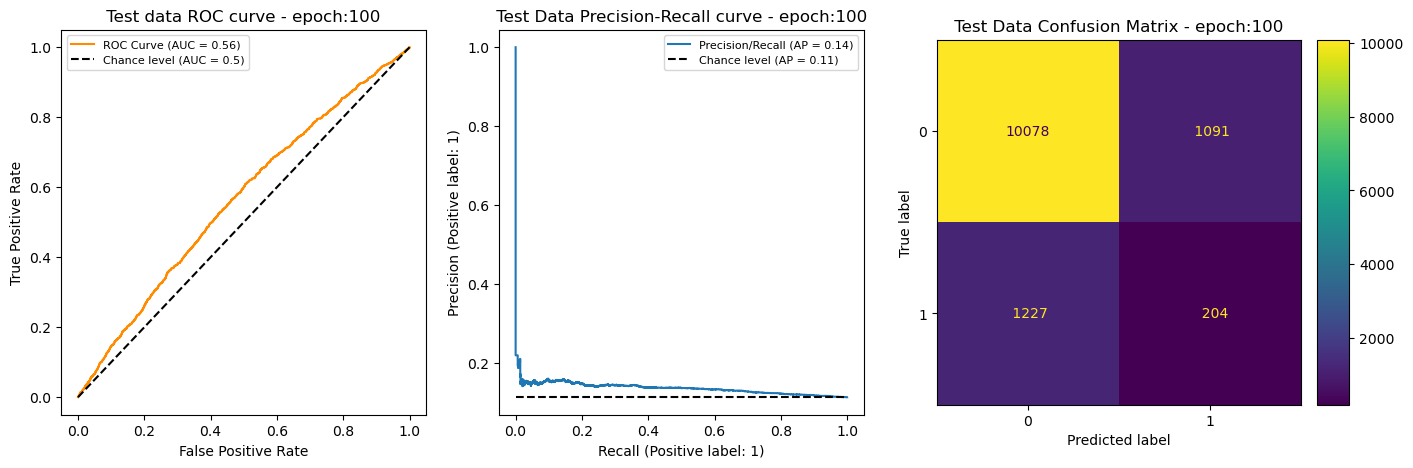

./saved_models/profile_models/NN_1482profiles_cpb600_20240913_0700_ep_100
 Val   Acc : 81.84 %    ROC Auc: 0.5428    PR Auc:0.1398    F1: 0.1398    Prec: 0.1502  Recall: 0.1308    

 Val Label counts:  True: [11178  1422] 	 Pred: [11362  1238] 

 Val Data Classification Report: - epoch:100 

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     11178
           1       0.15      0.13      0.14      1422

    accuracy                           0.82     12600
   macro avg       0.52      0.52      0.52     12600
weighted avg       0.81      0.82      0.81     12600



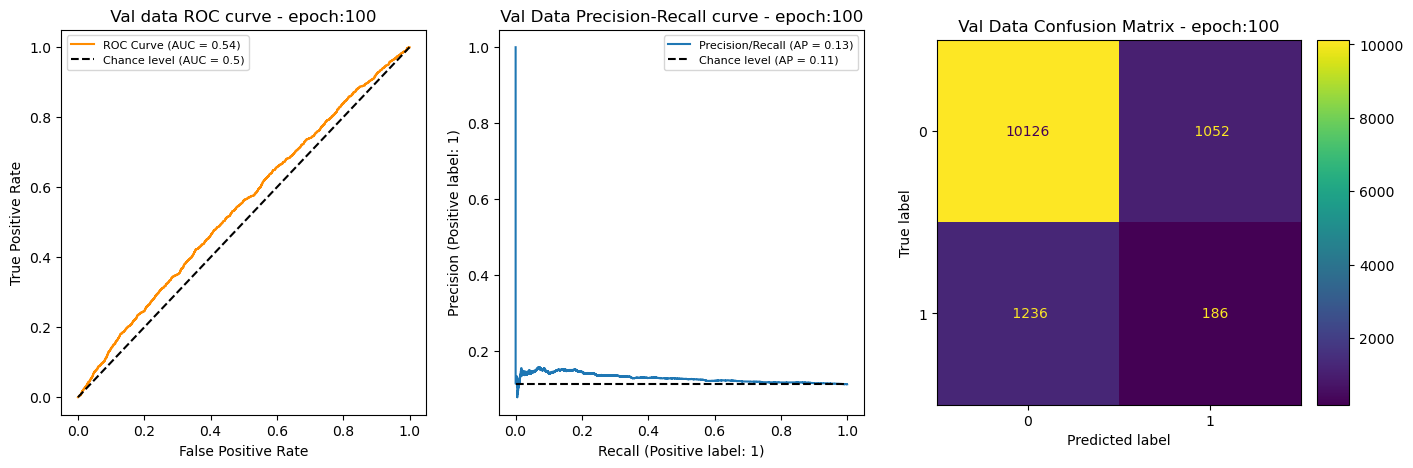

./saved_models/profile_models/NN_1482profiles_cpb600_20240913_0700_ep_100
 Train Acc : 97.10 %    ROC Auc: 0.9900    PR Auc:0.8695    F1: 0.8695    Prec: 0.9200  Recall: 0.8242    

 Train Label counts:  True: [11121  1479] 	 Pred: [11275  1325] 

 Train Data Classification Report: - epoch:100 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11121
           1       0.92      0.82      0.87      1479

    accuracy                           0.97     12600
   macro avg       0.95      0.91      0.93     12600
weighted avg       0.97      0.97      0.97     12600



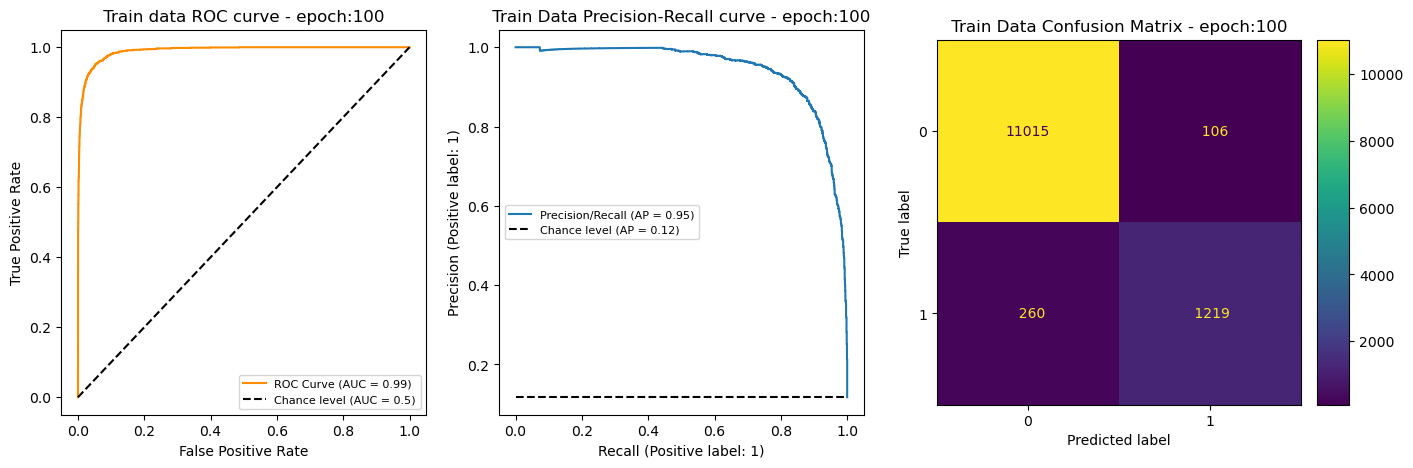

In [46]:
ep = 100
run_classification_inference(model, CKPT_FILE, ep, data_loader, 'test', DEVICE)
run_classification_inference(model, CKPT_FILE, ep, data_loader, 'val', DEVICE)
run_classification_inference(model, CKPT_FILE, ep, data_loader, 'train', DEVICE)

### t3 old

 VAL   Acc : 81.49 % 	 roc_auc: 0.5497 	 Precision: 0.1513 	 Recall: 0.1256 	 F1: 0.1372

 VAL Label counts:  True: [19068  2532] 	 Pred: [19498  2102] 

 VAL Data Classification Report: - epoch:100 

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     19068
           1       0.15      0.13      0.14      2532

    accuracy                           0.81     21600
   macro avg       0.52      0.52      0.52     21600
weighted avg       0.80      0.81      0.81     21600



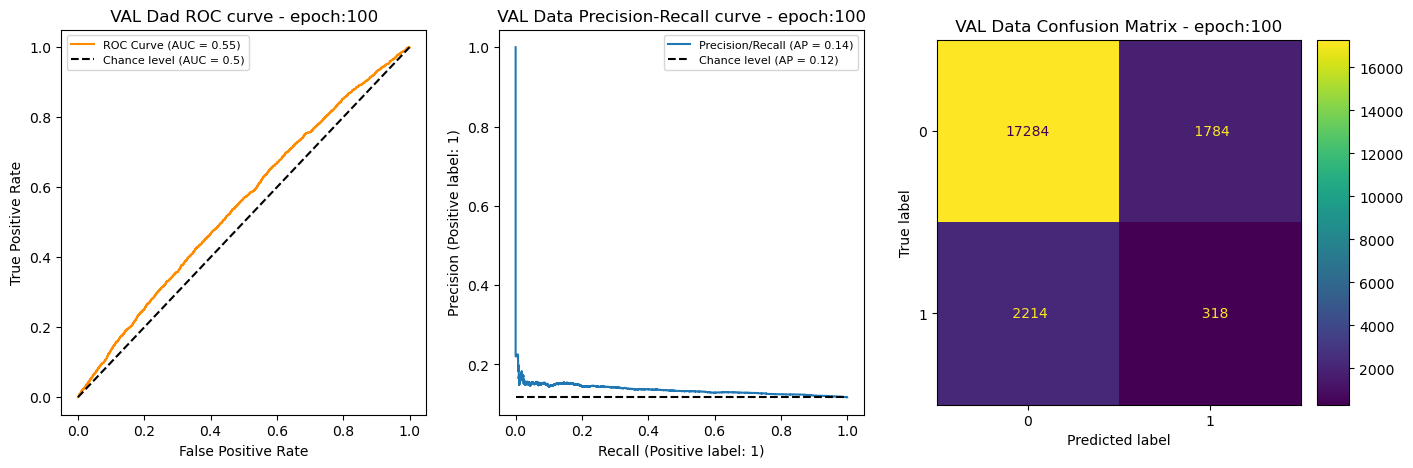

 VAL   Acc : 81.01 % 	 roc_auc: 0.5486 	 Precision: 0.1480 	 Recall: 0.1303 	 F1: 0.1386

 VAL Label counts:  True: [19068  2532] 	 Pred: [19370  2230] 

 VAL Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     19068
           1       0.15      0.13      0.14      2532

    accuracy                           0.81     21600
   macro avg       0.52      0.52      0.52     21600
weighted avg       0.80      0.81      0.80     21600



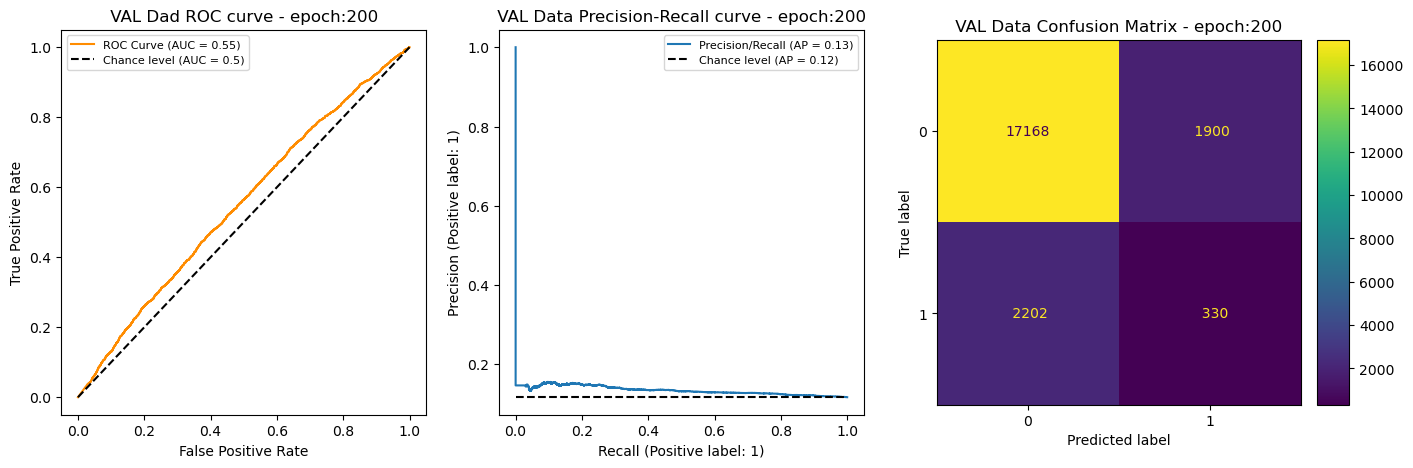

 VAL   Acc : 80.86 % 	 roc_auc: 0.5477 	 Precision: 0.1492 	 Recall: 0.1347 	 F1: 0.1416

 VAL Label counts:  True: [19068  2532] 	 Pred: [19315  2285] 

 VAL Data Classification Report: - epoch:300 

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     19068
           1       0.15      0.13      0.14      2532

    accuracy                           0.81     21600
   macro avg       0.52      0.52      0.52     21600
weighted avg       0.80      0.81      0.80     21600



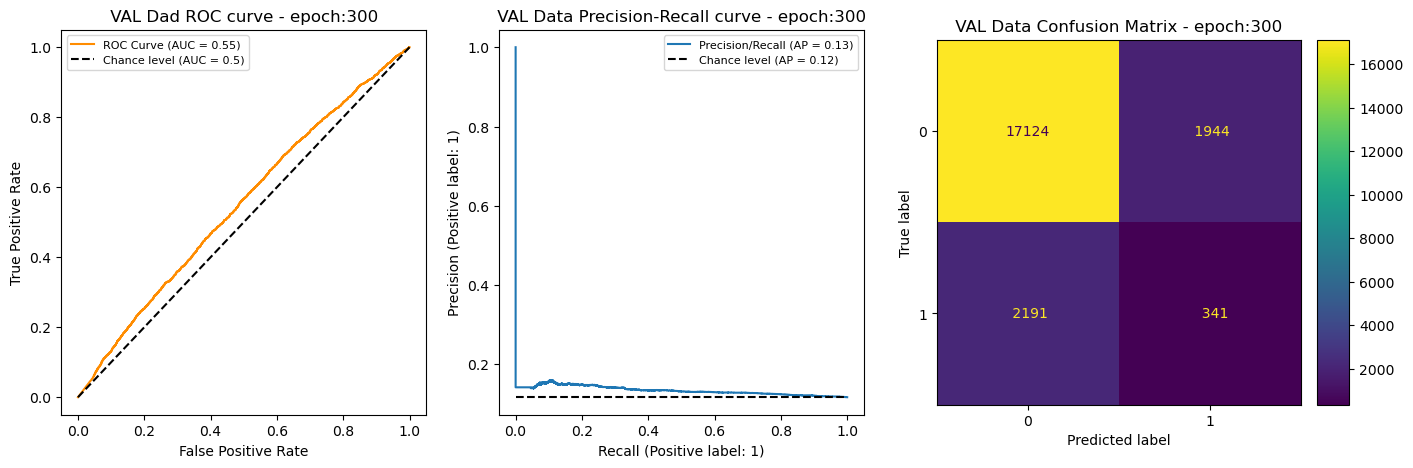

In [25]:
data = 'val'
for ep in [100, 200, 300 ]:
    model, optimizer, scheudler, loaded_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_file.format(ep=ep), ckpt_path = CKPT_PATH)
    _ = model.eval();
    mdl_outputs = run_model_on_test_data(model, data_loader[data], device, title = data, verbose = False)
    mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data,  verbose = True)
    plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )
    plt.show()

In [ ]:
print(checkpoint_file)
print(checkpoint_file.format(ep=200))

ep = 200
model, optimizer, scheudler, loaded_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_file.format(ep=ep), ckpt_path = CKPT_PATH)
_ = model.eval()

 TEST  Acc : 82.15 % 	 roc_auc: 0.5736 	 Precision: 0.1459 	 Recall: 0.1333 	 F1: 0.1393

 TEST Label counts:  True: [6420  780] 	 Pred: [6487  713] 

 TEST Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      6420
           1       0.15      0.13      0.14       780

    accuracy                           0.82      7200
   macro avg       0.52      0.52      0.52      7200
weighted avg       0.81      0.82      0.82      7200



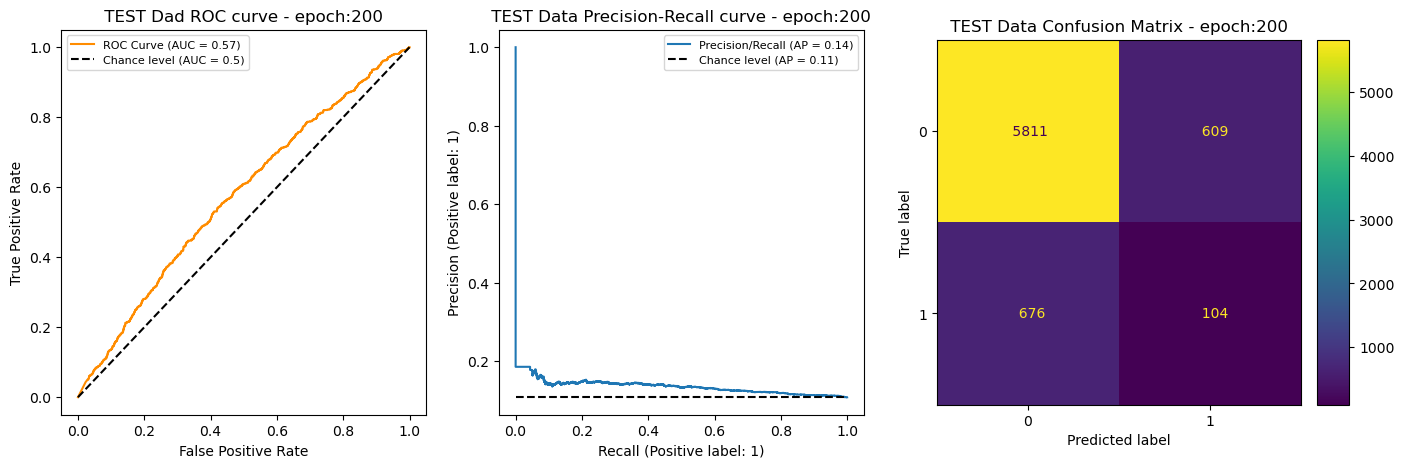

In [28]:
data = 'test'
mdl_outputs = run_model_on_test_data(model, data_loader[data], device, num_batches = 4, title =data, verbose = False)
mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data, verbose = True)
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )

 VAL   Acc : 80.76 % 	 roc_auc: 0.5614 	 Precision: 0.1485 	 Recall: 0.1182 	 F1: 0.1317

 VAL Label counts:  True: [6312  888] 	 Pred: [6493  707] 

 VAL Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      6312
           1       0.15      0.12      0.13       888

    accuracy                           0.81      7200
   macro avg       0.51      0.51      0.51      7200
weighted avg       0.79      0.81      0.80      7200



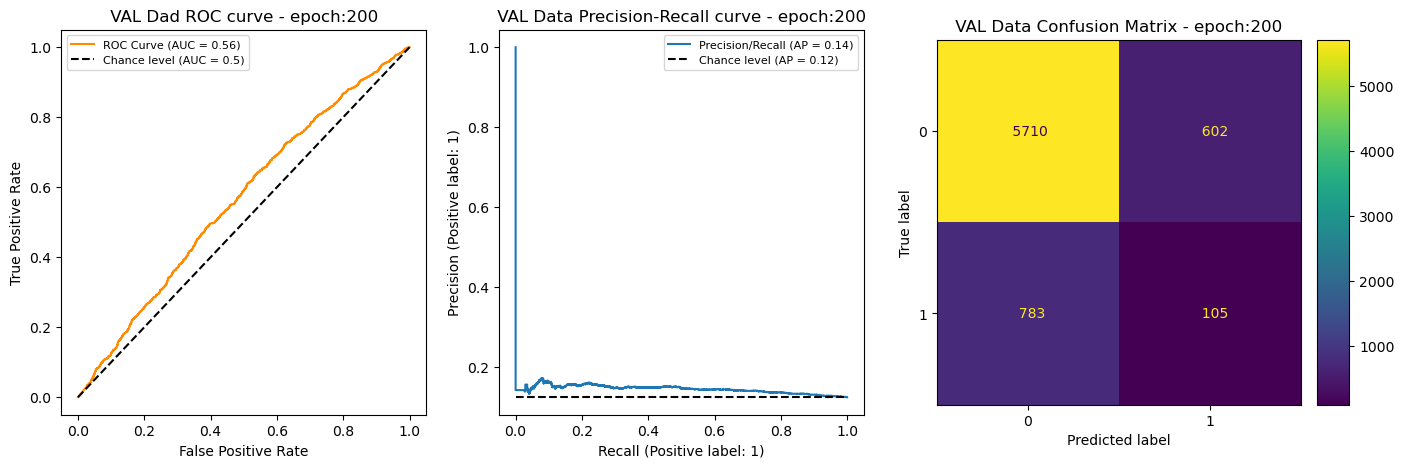

In [29]:
data = 'val'
mdl_outputs = run_model_on_test_data(model, data_loader[data], device, num_batches = 4, title =data, verbose = False)
mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data, verbose = True)
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )

 TRAIN Acc : 99.39 % 	 roc_auc: 0.9992 	 Precision: 0.9805 	 Recall: 0.9663 	 F1: 0.9733

 TRAIN Label counts:  True: [6369  831] 	 Pred: [6381  819] 

 TRAIN Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6369
           1       0.98      0.97      0.97       831

    accuracy                           0.99      7200
   macro avg       0.99      0.98      0.98      7200
weighted avg       0.99      0.99      0.99      7200



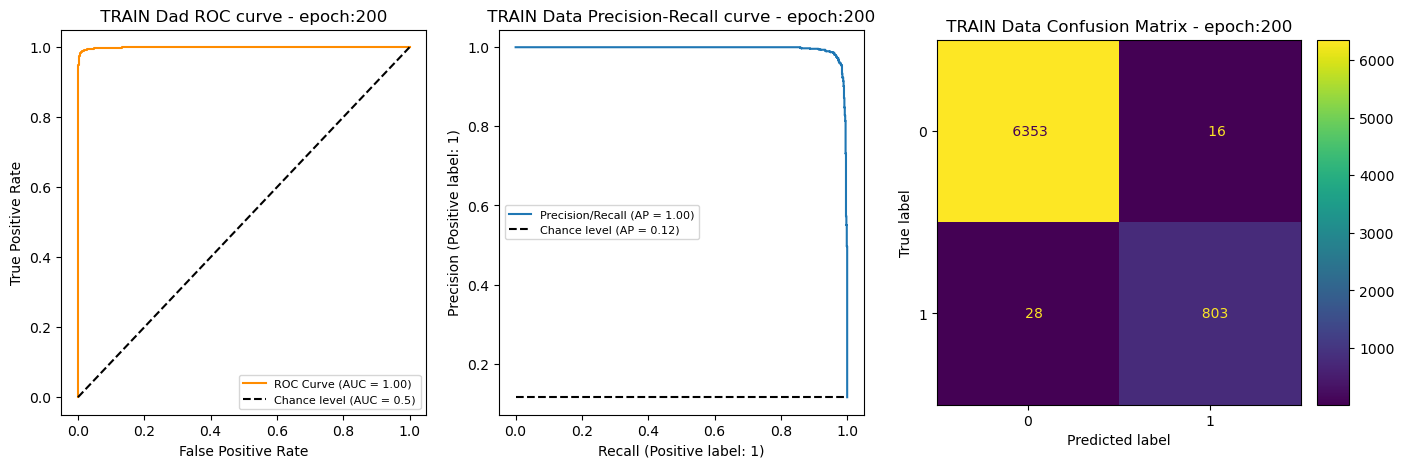

In [30]:
data = 'train'
mdl_outputs = run_model_on_test_data(model, data_loader[data], device, num_batches = 4, title =data, verbose = False)
mo = compute_classification_metrics(mdl_outputs, epochs = loaded_epoch, title = data, verbose = True)
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, title = data, epochs = loaded_epoch )
_ = model.train()

# Inference evaluation - (Batch Norm 512/512/128)

 - Model : **20241004_1600** - 4 layer with Batch Norm and ReLU nonlinearity

In [47]:
AE_LATENT_DIM = 1471
RUN_DATETIME = '20241004_1600'

input_num_cols = AE_LATENT_DIM + len(METADATA_COLS)

MODEL_TYPE = 'batch_norm'
n_input    = AE_LATENT_DIM  # the embedding dimensionality 
 
n_hidden_1 = 512  # the number of neurons in the hidden layer of the MLP
n_hidden_2 = 512  # the number of neurons in the hidden layer of the MLP
n_hidden_3 = 128

CKPT_FILE_BASE = f"NN_{input_num_cols}profiles_cpb{COMPOUNDS_PER_BATCH}_{RUN_DATETIME}_ep_{{ep}}"
CKPT_FILE = os.path.join(CKPT_PATH, CKPT_FILE_BASE )
print(CKPT_FILE)
print(CKPT_FILE.format(ep=999))
print()


./saved_models/profile_models/NN_1482profiles_cpb600_20241004_1600_ep_{ep}
./saved_models/profile_models/NN_1482profiles_cpb600_20241004_1600_ep_999



In [48]:
# data_loader = define_inference_datasets(cellpainting_args, AE_RUNMODE, AE_DATETIME, input_num_cols, AE_CKPTTYPE, INPUT_PATH)
model = build_model(MODEL_TYPE, input = n_input, hidden_1 = n_hidden_1, hidden_2 = n_hidden_2, hidden_3=n_hidden_3, device =DEVICE)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Mult-Adds                 Trainable
Sequential                               [30, 1471]                [30, 1]                   --                             --                   --                        True
├─Linear: 1-1                            [30, 1471]                [30, 512]                 753,664                    69.50%                   22,609,920                True
│    └─weight                                                                                ├─753,152
│    └─bias                                                                                  └─512
├─BatchNorm1d: 1-2                       [30, 512]                 [30, 512]                 1,024                       0.09%                   30,720                    True
│    └─weight                                                                            

### t0

./saved_models/profile_models/NN_1482profiles_cpb600_20241004_1600_ep_100
 Val   Acc : 84.48 % 	 roc_auc: 0.5520 	 Prec: 0.1620 	 Recall: 0.0900  Avg Prec:0.1157 	 F1: 0.1157

 Val Label counts:  True: [11178  1422] 	 Pred: [11810   790] 

 Val Data Classification Report: - epoch:100 

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     11178
           1       0.16      0.09      0.12      1422

    accuracy                           0.84     12600
   macro avg       0.53      0.52      0.52     12600
weighted avg       0.81      0.84      0.82     12600



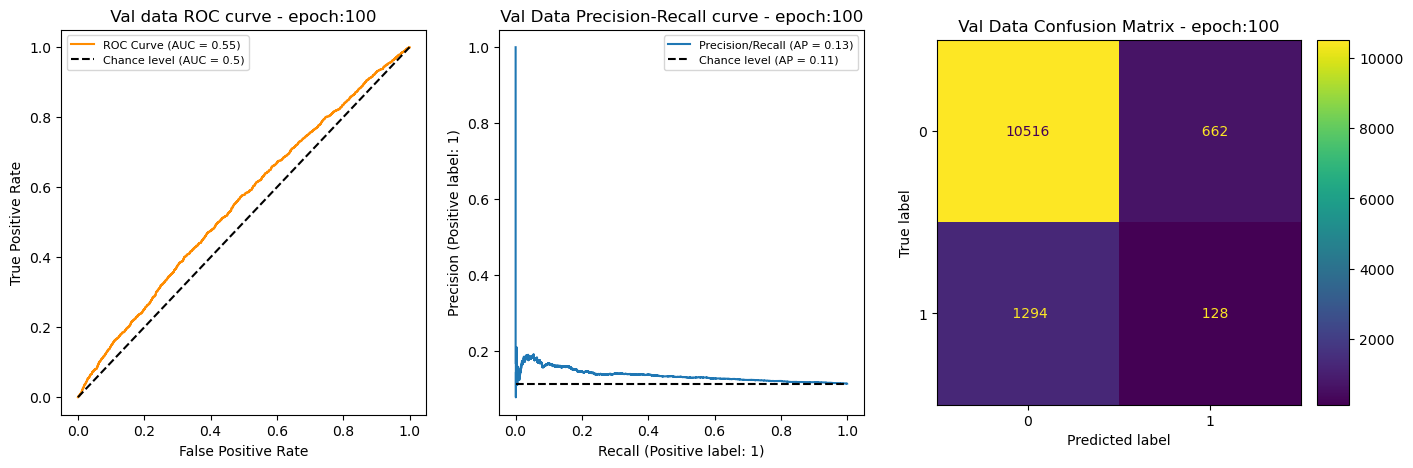

./saved_models/profile_models/NN_1482profiles_cpb600_20241004_1600_ep_200
 Val   Acc : 83.20 % 	 roc_auc: 0.5466 	 Prec: 0.1542 	 Recall: 0.1090  Avg Prec:0.1277 	 F1: 0.1277

 Val Label counts:  True: [11178  1422] 	 Pred: [11595  1005] 

 Val Data Classification Report: - epoch:200 

              precision    recall  f1-score   support

           0       0.89      0.92      0.91     11178
           1       0.15      0.11      0.13      1422

    accuracy                           0.83     12600
   macro avg       0.52      0.52      0.52     12600
weighted avg       0.81      0.83      0.82     12600



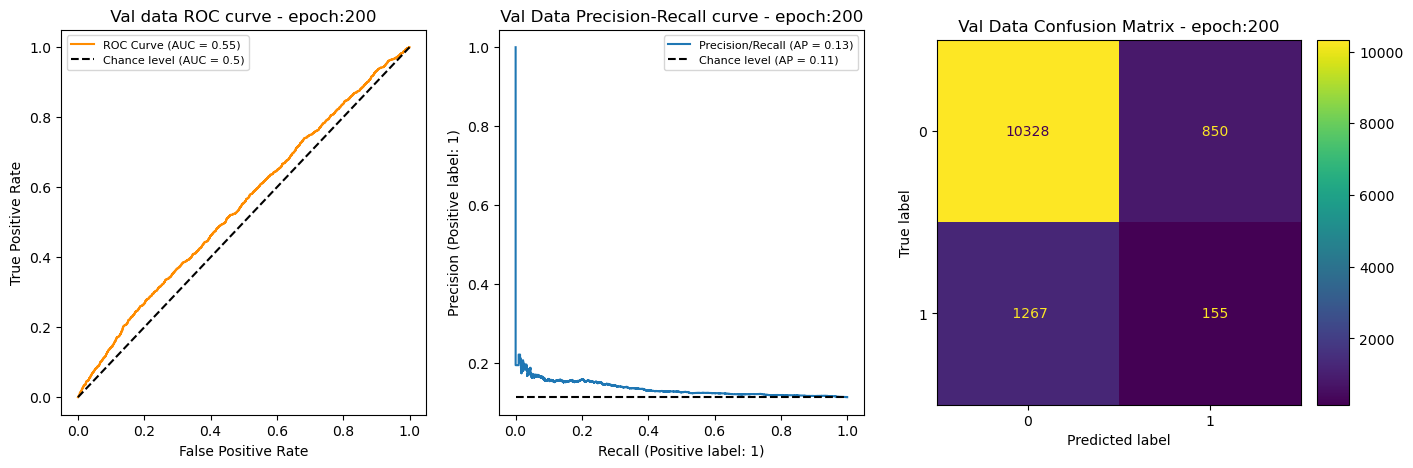

./saved_models/profile_models/NN_1482profiles_cpb600_20241004_1600_ep_300
 Val   Acc : 83.22 % 	 roc_auc: 0.5456 	 Prec: 0.1561 	 Recall: 0.1104  Avg Prec:0.1293 	 F1: 0.1293

 Val Label counts:  True: [11178  1422] 	 Pred: [11594  1006] 

 Val Data Classification Report: - epoch:300 

              precision    recall  f1-score   support

           0       0.89      0.92      0.91     11178
           1       0.16      0.11      0.13      1422

    accuracy                           0.83     12600
   macro avg       0.52      0.52      0.52     12600
weighted avg       0.81      0.83      0.82     12600



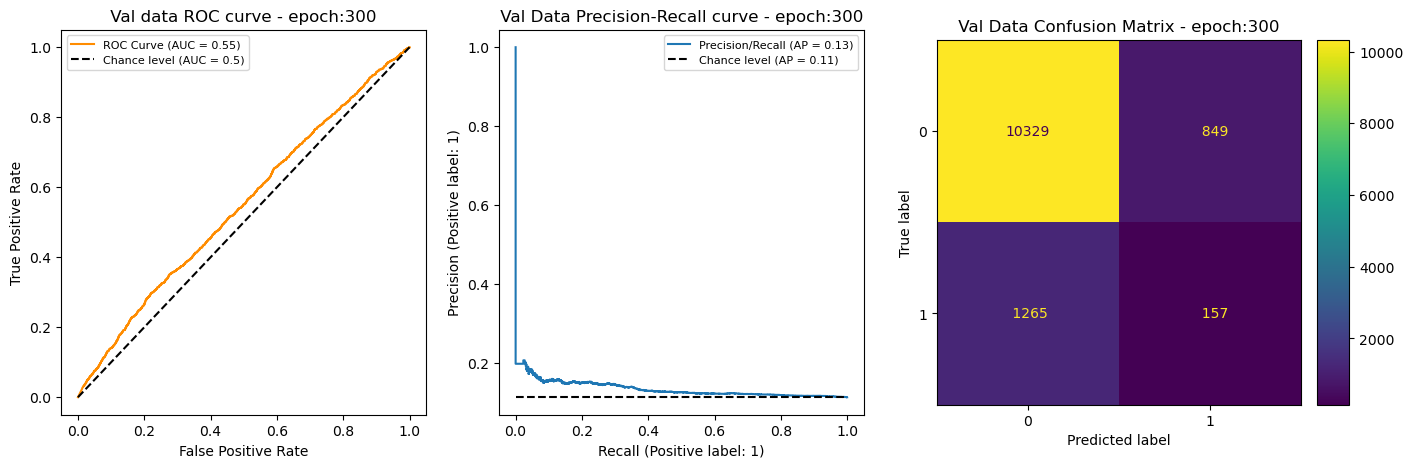

./saved_models/profile_models/NN_1482profiles_cpb600_20241004_1600_ep_400
 Val   Acc : 83.49 % 	 roc_auc: 0.5452 	 Prec: 0.1573 	 Recall: 0.1062  Avg Prec:0.1268 	 F1: 0.1268

 Val Label counts:  True: [11178  1422] 	 Pred: [11640   960] 

 Val Data Classification Report: - epoch:400 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11178
           1       0.16      0.11      0.13      1422

    accuracy                           0.83     12600
   macro avg       0.52      0.52      0.52     12600
weighted avg       0.81      0.83      0.82     12600



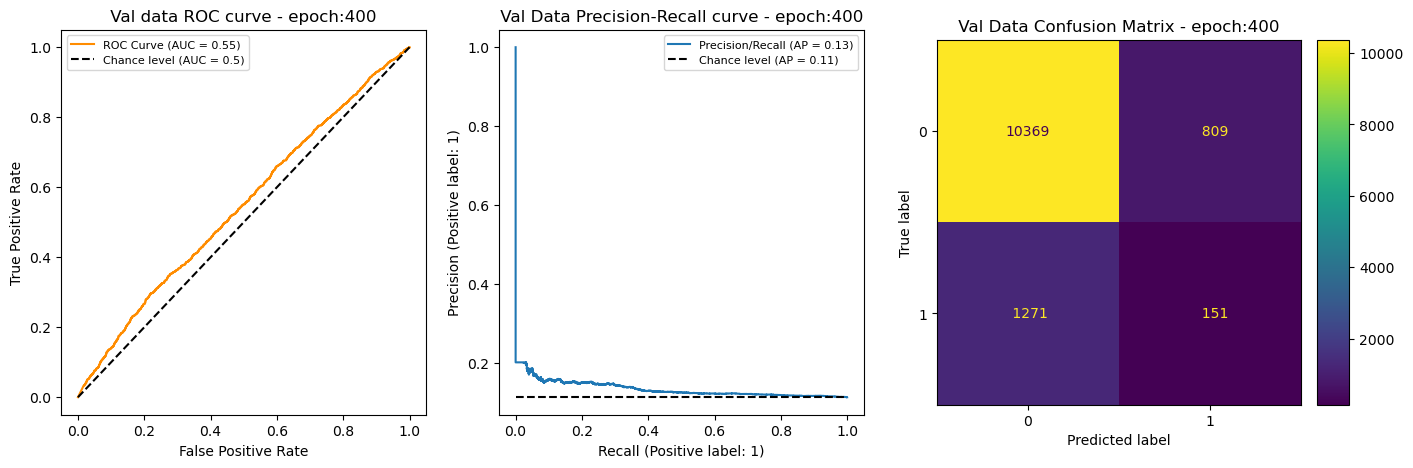

In [22]:
data_type = 'val'
for epoch in [100,200,300, 400 ]:
    run_classification_inference(model, CKPT_FILE, epoch, data_loader, data_type, DEVICE)

### t1

./saved_models/profile_models/NN_1482profiles_cpb600_20241004_1600_ep_400
400 Test  Acc : 83.27 %    ROC Auc: 0.5507    PR Auc:0.1209    F1: 0.1209    Prec: 0.1499  Recall: 0.1013    

 Test Label counts:  True: [11169  1431] 	 Pred: [11633   967] 

 Test Data Classification Report: - epoch:400 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11169
           1       0.15      0.10      0.12      1431

    accuracy                           0.83     12600
   macro avg       0.52      0.51      0.51     12600
weighted avg       0.81      0.83      0.82     12600



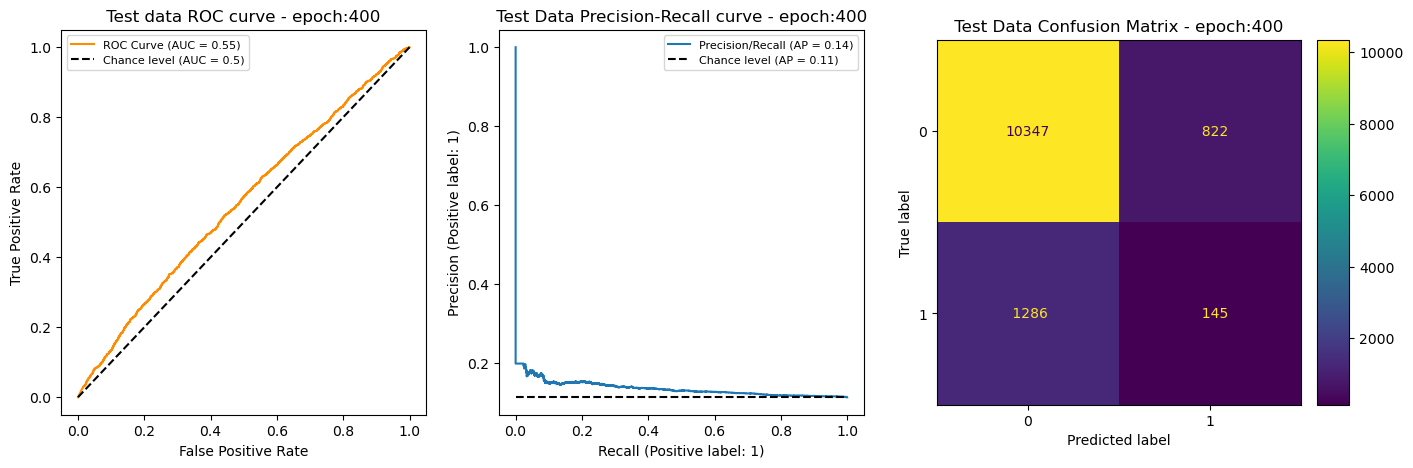

./saved_models/profile_models/NN_1482profiles_cpb600_20241004_1600_ep_400
400 Val   Acc : 83.49 %    ROC Auc: 0.5452    PR Auc:0.1268    F1: 0.1268    Prec: 0.1573  Recall: 0.1062    

 Val Label counts:  True: [11178  1422] 	 Pred: [11640   960] 

 Val Data Classification Report: - epoch:400 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11178
           1       0.16      0.11      0.13      1422

    accuracy                           0.83     12600
   macro avg       0.52      0.52      0.52     12600
weighted avg       0.81      0.83      0.82     12600



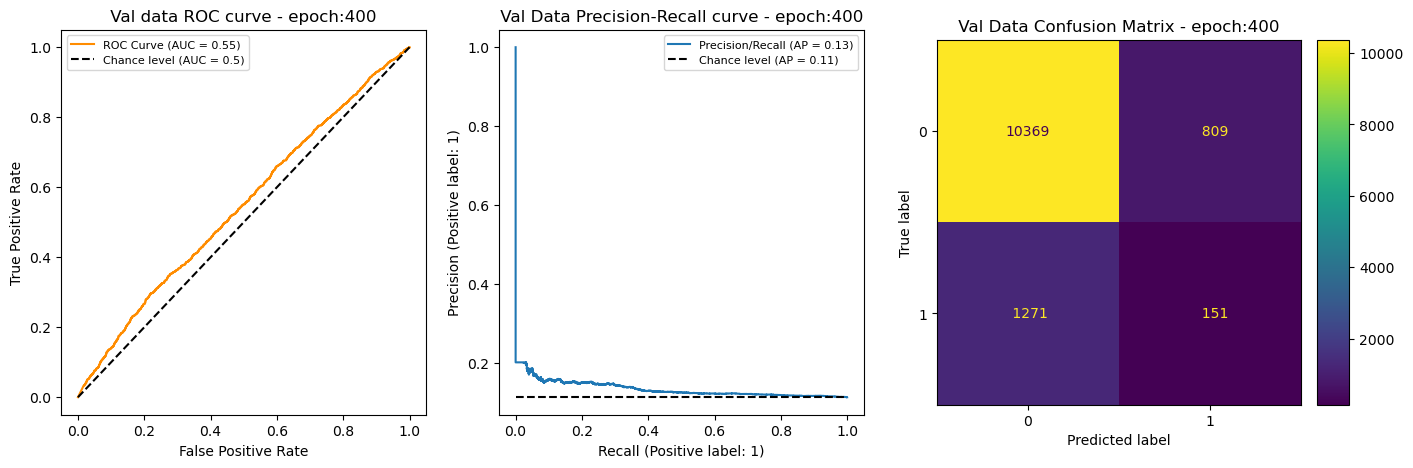

./saved_models/profile_models/NN_1482profiles_cpb600_20241004_1600_ep_400
400 Train Acc : 100.00 %    ROC Auc: 1.0000    PR Auc:1.0000    F1: 1.0000    Prec: 1.0000  Recall: 1.0000    

 Train Label counts:  True: [11121  1479] 	 Pred: [11121  1479] 

 Train Data Classification Report: - epoch:400 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11121
           1       1.00      1.00      1.00      1479

    accuracy                           1.00     12600
   macro avg       1.00      1.00      1.00     12600
weighted avg       1.00      1.00      1.00     12600



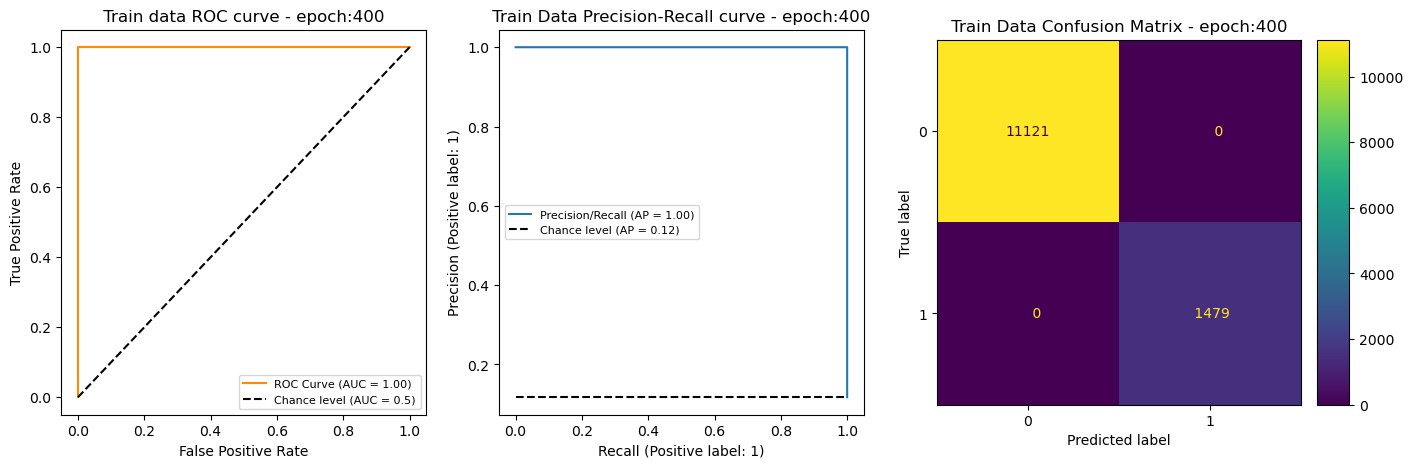

In [53]:
ep = 400
run_classification_inference(model, CKPT_FILE, ep, data_loader, 'test', DEVICE)
run_classification_inference(model, CKPT_FILE, ep, data_loader, 'val', DEVICE)
run_classification_inference(model, CKPT_FILE, ep, data_loader, 'train', DEVICE)